# Prédiction Prix Immobilier 

### IMPORTS 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
import joblib
import warnings
warnings.filterwarnings('ignore')

# Configuration des graphiques
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

### GÉNÉRATION DU DATASET

In [3]:
# Génération du dataset
np.random.seed(42)
n_samples = 1000

# Génération des features
surface = np.random.normal(120, 40, n_samples)
surface = np.clip(surface, 30, 300)  
# Surface en m², moyenne 120, écart-type 40, bornée entre 30 et 300 m² , 
# les valeurs inférieures à 30 et supérieures à 300 sont remplacées par ces bornes, distribution Gaussienne  

chambres = np.random.choice([1, 2, 3, 4, 5, 6], n_samples, p=[0.05, 0.15, 0.3, 0.35, 0.12, 0.03]) # 
# Nombre de chambres, distribution réaliste avec plus de 2 et 3 chambres
# 5% de maisons avec 1 chambre, 15% avec 2, 30% avec 3, 35% avec 4, 12% avec 5 et 3% avec 6 chambres

salles_bain = np.random.choice([1, 2, 3, 4], n_samples, p=[0.3, 0.5, 0.18, 0.02]) 

age_maison = np.random.exponential(15, n_samples) 
# Âge de la maison, distribution exponentielle avec une moyenne de 15 ans (distribution de Poisson)
age_maison = np.clip(age_maison, 0, 100)

distance_centre = np.random.gamma(2, 5, n_samples) 
# Distance au centre-ville, distribution gamma pour simuler des distances réalistes, 
# distribution gamma avec forme 2 et échelle 5
distance_centre = np.clip(distance_centre, 1, 50)

crime_rate = np.random.beta(2, 5, n_samples) * 10   # Taux de criminalité, distribution bêta pour simuler un taux entre 0 et 10
ecoles_score = np.random.normal(75, 15, n_samples) #  
ecoles_score = np.clip(ecoles_score, 20, 100)

transport_access = np.random.choice(range(1, 11), n_samples)
jardin = np.random.choice([0, 1], n_samples, p=[0.3, 0.7])
garage = np.random.choice([0, 1, 2, 3], n_samples, p=[0.2, 0.4, 0.3, 0.1])

# Génération du prix (avec relations réalistes)
prix = (
    surface * 2500 +  # 2500€/m²
    chambres * 15000 +  # 15k€ par chambre
    salles_bain * 8000 +  # 8k€ par salle de bain
    -age_maison * 500 +  # Dépréciation avec l'âge
    -distance_centre * 1000 +  # Prix baisse avec la distance
    -crime_rate * 2000 +  # Prix baisse avec le crime
    ecoles_score * 400 +  # Bonus écoles
    transport_access * 3000 +  # Bonus transport
    jardin * 25000 +  # Bonus jardin
    garage * 12000 +  # Bonus garage
    np.random.normal(0, 20000, n_samples)  # Bruit
) 

# Ajout de quelques outliers
outlier_indices = np.random.choice(n_samples, 20, replace=False)
prix[outlier_indices] *= np.random.uniform(1.5, 2.5, 20)

In [4]:
# Création du DataFrame
data = pd.DataFrame({
    'surface': surface,
    'chambres': chambres,
    'salles_bain': salles_bain,
    'age_maison': age_maison,
    'distance_centre': distance_centre,
    'crime_rate': crime_rate,
    'ecoles_score': ecoles_score,
    'transport_access': transport_access,
    'jardin': jardin,
    'garage': garage,
    'prix': prix
})

# Ajout de quelques valeurs manquantes (simulation réaliste)
missing_indices = np.random.choice(n_samples, 30, replace=False)
data.loc[missing_indices[:15], 'ecoles_score'] = np.nan
data.loc[missing_indices[15:], 'transport_access'] = np.nan

print("Dataset généré avec succès!")
print(f"Shape: {data.shape}")

Dataset généré avec succès!
Shape: (1000, 11)


### EXPLORATION DES DONNÉES

In [ ]:
print("🔍 EXPLORATION DES DONNÉES")
print("="*60)

# Affichage des premières lignes
print("Premières lignes du dataset:")
print(data.head())

# Informations générales sur le dataset
print("\nInformations sur le dataset:")
print(data.info())

# Statistiques descriptives
print("\nStatistiques descriptives:")
print(data.describe())


# Vérification des valeurs manquantes 

print("\nValeurs manquantes:")
print("\n Y'a t-il des valeurs manquantes ? : ", data.isnull().values.any())
print(data.isna().sum())
print("\nSomme totale des valeurs manquantes: ", np.isnan(data).sum().sum())

🔍 EXPLORATION DES DONNÉES
Premières lignes du dataset:
      surface  chambres  salles_bain  age_maison  distance_centre  crime_rate  \
0  139.868566         2            1   15.675419         7.864902    5.000285   
1  114.469428         2            1    1.154923         7.854394    4.009127   
2  145.907542         4            1    7.061313        12.041471    2.714066   
3  180.921194         4            2   24.430423        22.114938    3.617181   
4  110.633865         1            3    8.523438        33.275709    5.252706   

   ecoles_score  transport_access  jardin  garage           prix  
0     83.881709               5.0       1       1  463961.756736  
1     75.687120               9.0       0       1  380399.542639  
2     76.031953               5.0       0       1  444855.974915  
3     59.823282               7.0       1       2  563920.337502  
4     70.079022               7.0       0       2  301940.138706  

Informations sur le dataset:
<class 'pandas.core.frame.

### VISUALISATIONS EXPLORATOIRES


📊 VISUALISATIONS EXPLORATOIRES


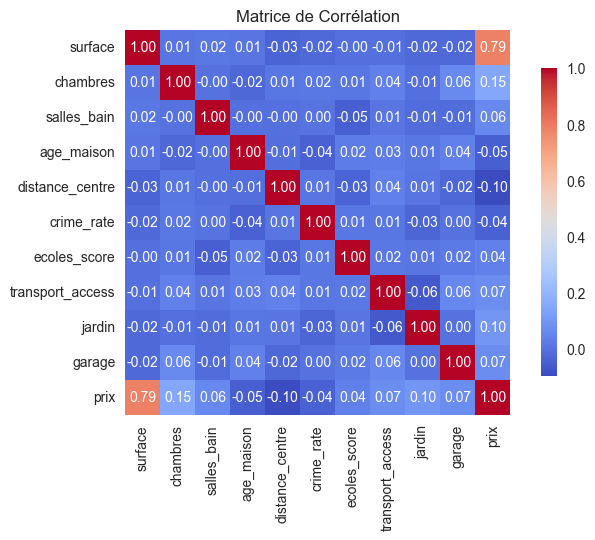

<Axes: xlabel='prix', ylabel='Density'>

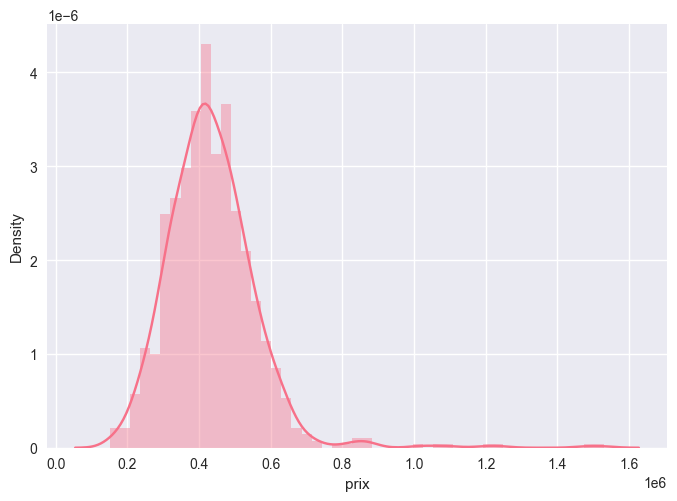

In [ ]:
print("\n📊 VISUALISATIONS EXPLORATOIRES")
print("="*60)

# Matrice de corrélation
matrice_correlation = data.corr()
plt.figure(figsize=(8, 5))
sns.heatmap(matrice_correlation, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title("Matrice de Corrélation")
plt.show()


# Distribution de la variable cible (prix)
sns.distplot(data['prix'])

# On a une distribution normale


📊 VISUALISATIONS EXPLORATOIRES


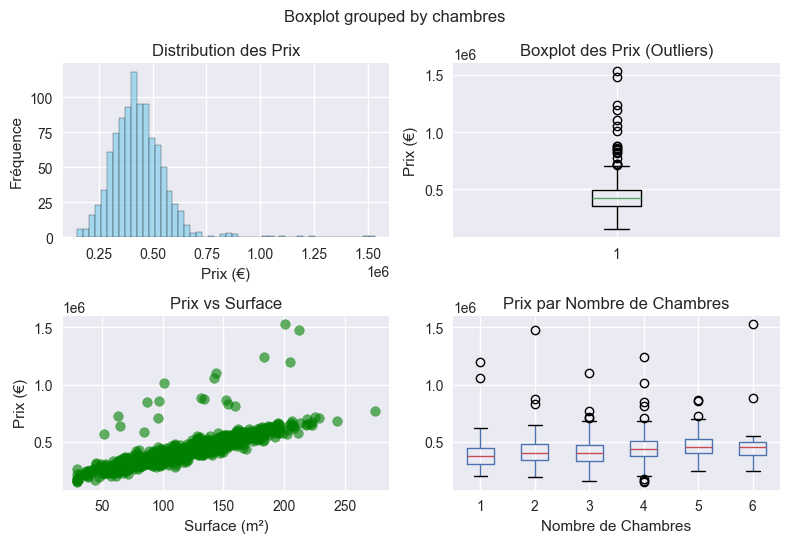

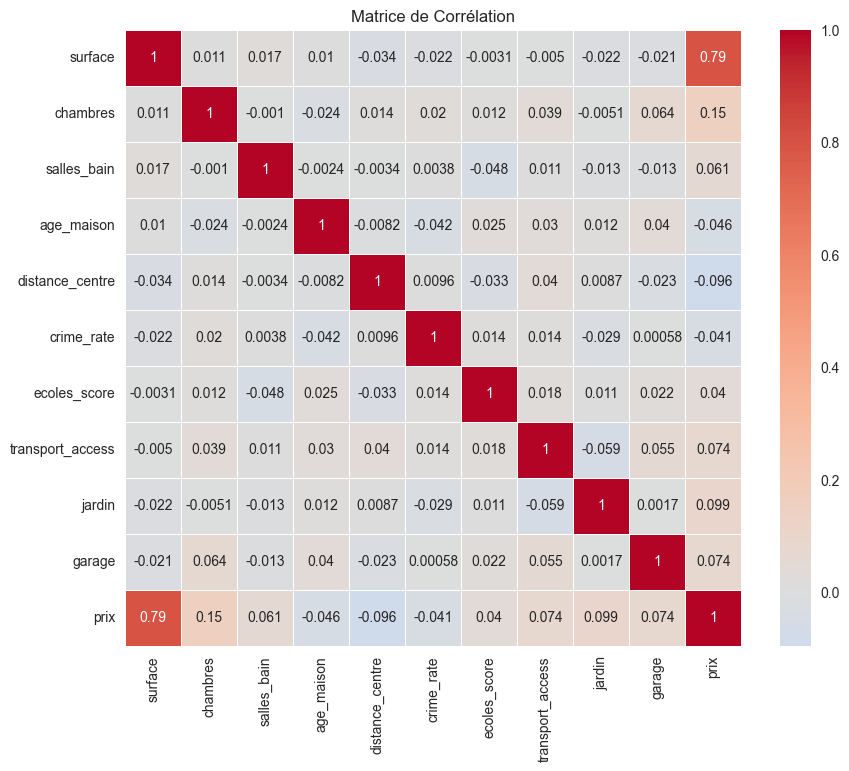

Corrélations les plus fortes avec le prix:


surface             0.789415
chambres            0.150125
jardin              0.099003
distance_centre     0.095540
garage              0.073857
transport_access    0.073829
salles_bain         0.060764
age_maison          0.046404
crime_rate          0.041007
ecoles_score        0.040298
Name: prix, dtype: float64

In [ ]:
print("\n📊 VISUALISATIONS EXPLORATOIRES")
print("="*60)

# Configuration des graphiques
plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 2)

# 1. Distribution de la variable cible
axes[0,0].hist(data['prix'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Distribution des Prix')
axes[0,0].set_xlabel('Prix (€)')
axes[0,0].set_ylabel('Fréquence')

# 2. Boxplot pour détecter les outliers
axes[0,1].boxplot(data['prix'])
axes[0,1].set_title('Boxplot des Prix (Outliers)')
axes[0,1].set_ylabel('Prix (€)')

# 3. Corrélation prix vs surface
axes[1,0].scatter(data['surface'], data['prix'], alpha=0.6, color='green')
axes[1,0].set_xlabel('Surface (m²)')
axes[1,0].set_ylabel('Prix (€)')
axes[1,0].set_title('Prix vs Surface')

# 4. Prix par nombre de chambres
data.boxplot(column='prix', by='chambres', ax=axes[1,1])
axes[1,1].set_title('Prix par Nombre de Chambres')
axes[1,1].set_xlabel('Nombre de Chambres')

plt.tight_layout()
plt.show()

# Matrice de corrélation
plt.figure(figsize=(10, 8))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Matrice de Corrélation')
plt.show()

print("Corrélations les plus fortes avec le prix:")
prix_corr = correlation_matrix['prix'].abs().sort_values(ascending=False)[1:]  # Exclure prix vs prix
prix_corr

### PREPROCESSING

In [ ]:
print("\n🔧 PREPROCESSING")
print("="*60)

# Gestion des valeurs manquantes


# Remplacer les valeurs manquantes par la médiane (ou la moyenne ou la mode (valeur la plus présente))
for var in data.columns:
    data[var].fillna(data[var].median(), inplace=True)
    
print("Y'a t-il des valeurs manquantes ? : ", data.isnull().values.any())

# Détection et traitement des outliers

# sns.boxplot(data=data, x='prix')


🔧 PREPROCESSING
Y'a t-il des valeurs manquantes ? :  False


RMQ:
* Je souhaite traiter les outliers en utilisants différentes méthodes pour trouver et traiter les outliers afin de comprendre chacune d'elles et de comparer les résultats obtenus

Détection et traitement des outliers

a) Méthode Z-Score: 

	Valeur max: 820175.904523679
	Valeur min: 49035.15691866557
	Taille du dataset AVANT traitement des outliers (trimming): (1000, 11)
	Taille du dataset APRES traitement des outliers (trimming): (987, 11)
	Nombre d'outliers supprimés: 13

	Taille du dataset AVANT traitement des outliers (capping): (1000, 11)
	Taille du dataset APRES traitement des outliers (capping): (1000, 11)


<Axes: xlabel='prix'>

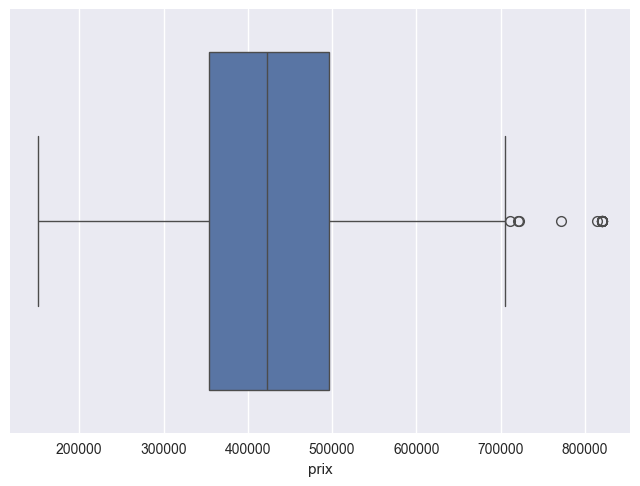

In [10]:
# a) La méthode Z-score 
print("a) Méthode Z-Score: \n")
max_limite = data['prix'].mean() + 3*data['prix'].std() 
min_limite = data['prix'].mean() - 3*data['prix'].std() 
print('\tValeur max:', max_limite)
print('\tValeur min:', min_limite)

# trimming - on supprime les valeurs en dehors des limites
data_1 = data.loc[(data['prix'] <= max_limite) & (data['prix'] >= min_limite)]
print("\tTaille du dataset AVANT traitement des outliers (trimming):", data.shape)
print("\tTaille du dataset APRES traitement des outliers (trimming):", data_1.shape)
print("\tNombre d'outliers supprimés:", data.shape[0] - data_1.shape[0])

# Capping - on remplace les valeurs en dehors des limites par les limites
data_1 = data.copy()
# On remplace les valeurs supérieures à max_limite par max_limite et les valeurs inférieures à min_limite par min_limite
data_1['prix'] = np.where(data_1['prix'] >= max_limite, max_limite, data_1['prix'])
data_1['prix'] = np.where(data_1['prix'] <= min_limite, min_limite, data_1['prix'])
print("\n\tTaille du dataset AVANT traitement des outliers (capping):", data.shape)
print("\tTaille du dataset APRES traitement des outliers (capping):", data_1.shape) 

sns.boxplot(data=data_1, x='prix')


b) Méthode IQR 

	Q1: 353979.50325245596
	Q3: 496741.69041037664
	IQR: 142762.18715792068
	Valeur max: 710884.9711472576
	Valeur min: 139836.22251557495
	Taille du dataset AVANT traitement des outliers (trimming): (1000, 11)
	Taille du dataset APRES traitement des outliers (trimming): (982, 11)
	Nombre d'outliers supprimés: 0

	Taille du dataset AVANT traitement des outliers (capping): (1000, 11)
	Taille du dataset APRES traitement des outliers (capping): (1000, 11)


<Axes: xlabel='prix'>

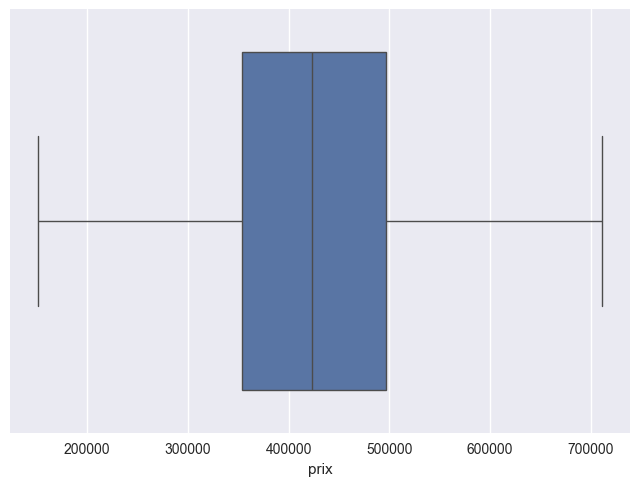

In [11]:
# b) La méthode IQR 
print("\nb) Méthode IQR \n")
Q1 = data['prix'].quantile(0.25)
Q3 = data['prix'].quantile(0.75)
IQR = Q3 - Q1
max_limite2 = Q3 + 1.5 * IQR
min_limite2 = Q1 - 1.5 * IQR

print('\tQ1:', Q1)
print('\tQ3:', Q3)
print('\tIQR:', IQR)
print('\tValeur max:', max_limite2)
print('\tValeur min:', min_limite2)

# trimming 
data_2 = data.loc[(data['prix'] <= max_limite2) & (data['prix'] >= min_limite2)]
print("\tTaille du dataset AVANT traitement des outliers (trimming):", data.shape)
print("\tTaille du dataset APRES traitement des outliers (trimming):", data_2.shape)
print("\tNombre d'outliers supprimés:", data.shape[0] - data_1.shape[0])

# Capping
data_2 = data.copy()
data_2['prix'] = np.where(data_2['prix'] >= max_limite2, max_limite2, data_2['prix'])
data_2['prix'] = np.where(data_2['prix'] <= min_limite2, min_limite2, data_2['prix'])
print("\n\tTaille du dataset AVANT traitement des outliers (capping):", data.shape)
print("\tTaille du dataset APRES traitement des outliers (capping):", data_2.shape)


sns.boxplot(data=data_2, x='prix')


c) Méthode des percentiles 

	Percentile 1: 204163.11428880205
	Percentile 99: 853490.6938535658
	Taille du dataset AVANT traitement des outliers (trimming): (1000, 11)
	Taille du dataset APRES traitement des outliers (trimming): (980, 11)
	Nombre d'outliers supprimés: 20

	Taille du dataset AVANT traitement des outliers (capping): (1000, 11)
	Taille du dataset APRES traitement des outliers (capping): (1000, 11)


<Axes: xlabel='prix'>

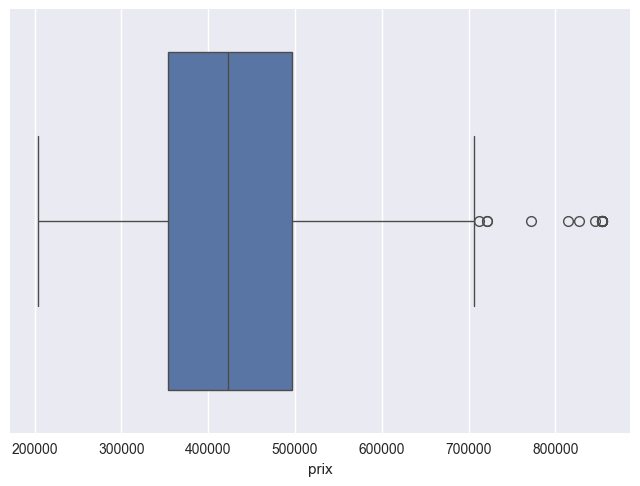

In [12]:
# c) La méthode des percentiles 
print("\nc) Méthode des percentiles \n")
percentile_1 = data['prix'].quantile(0.01)
percentile_99 = data['prix'].quantile(0.99)
print('\tPercentile 1:', percentile_1)
print('\tPercentile 99:', percentile_99)

# trimming
data_3 = data.loc[(data['prix'] <= percentile_99) & (data['prix'] >= percentile_1)]
print("\tTaille du dataset AVANT traitement des outliers (trimming):", data.shape)
print("\tTaille du dataset APRES traitement des outliers (trimming):", data_3.shape)
print("\tNombre d'outliers supprimés:", data.shape[0] - data_3.shape[0])

# Capping
data_3 = data.copy()
data_3['prix'] = np.where(data_3['prix'] >= percentile_99, percentile_99, data_3['prix'])
data_3['prix'] = np.where(data_3['prix'] <= percentile_1, percentile_1, data_3['prix'])
print("\n\tTaille du dataset AVANT traitement des outliers (capping):", data.shape)
print("\tTaille du dataset APRES traitement des outliers (capping):", data_3.shape)

sns.boxplot(data=data_3, x='prix')

Remarque :
D'apres les résultats obtenus, je vais utiliser la méthode IQR pour traiter les outliers, car elle est plus robuste et permet de conserver plus de données.


🔧 TRAITEMENT DES OUTLIERS - VERSION AMÉLIORÉE


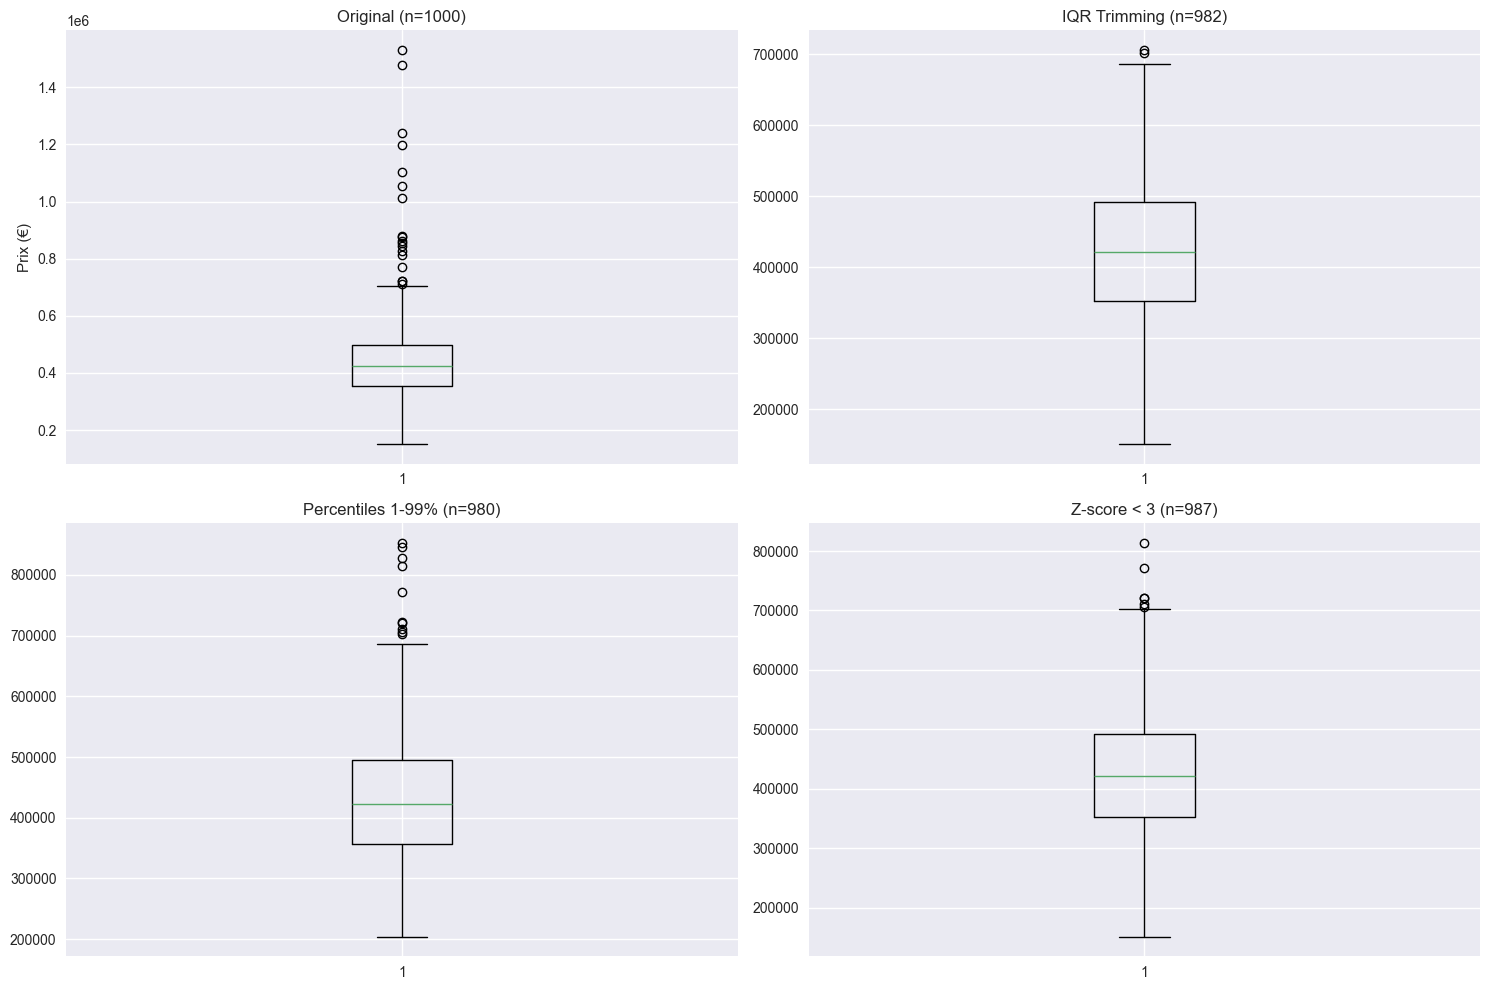

📊 COMPARAISON DES MÉTHODES:
Original: 1000 échantillons
IQR: 982 échantillons (-18)
Percentiles: 980 échantillons (-20)
Z-score: 987 échantillons (-13)

✅ MÉTHODE CHOISIE: IQR (conserve 982 échantillons)


In [13]:
# AMÉLIORATION : Traitement des outliers plus robuste
print("\n🔧 TRAITEMENT DES OUTLIERS - VERSION AMÉLIORÉE")
print("="*60)

# Comparaison visuelle des 3 méthodes
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Dataset original
axes[0,0].boxplot(data['prix'])
axes[0,0].set_title(f'Original (n={len(data)})')
axes[0,0].set_ylabel('Prix (€)')

# Méthode Z-score (CORRECTION : utilisez les bonnes limites)
Q1 = data['prix'].quantile(0.25)
Q3 = data['prix'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

data_iqr = data[(data['prix'] >= lower_bound) & (data['prix'] <= upper_bound)]
axes[0,1].boxplot(data_iqr['prix'])
axes[0,1].set_title(f'IQR Trimming (n={len(data_iqr)})')

# Méthode percentiles
data_perc = data[(data['prix'] >= data['prix'].quantile(0.01)) & 
                 (data['prix'] <= data['prix'].quantile(0.99))]
axes[1,0].boxplot(data_perc['prix'])
axes[1,0].set_title(f'Percentiles 1-99% (n={len(data_perc)})')

# Z-score
z_scores = np.abs((data['prix'] - data['prix'].mean()) / data['prix'].std())
data_zscore = data[z_scores < 3]
axes[1,1].boxplot(data_zscore['prix'])
axes[1,1].set_title(f'Z-score < 3 (n={len(data_zscore)})')

plt.tight_layout()
plt.show()

# DÉCISION FINALE
print("📊 COMPARAISON DES MÉTHODES:")
print(f"Original: {len(data)} échantillons")
print(f"IQR: {len(data_iqr)} échantillons (-{len(data)-len(data_iqr)})")
print(f"Percentiles: {len(data_perc)} échantillons (-{len(data)-len(data_perc)})")
print(f"Z-score: {len(data_zscore)} échantillons (-{len(data)-len(data_zscore)})")

# Choisir la méthode IQR (votre choix est correct !)
data_clean = data_iqr.copy()
print(f"\n✅ MÉTHODE CHOISIE: IQR (conserve {len(data_clean)} échantillons)")

### FEATURE ENGINEERING

In [ ]:
print("\n⚙️ FEATURE ENGINEERING")
print("="*60)

data_eng = data.copy()

# Création de nouvelles variables
print("🔧 Création des nouvelles features...")

data_eng['surface_par_chambre'] = data_eng['surface'] / data_eng['chambres']
data_eng['ratio_sdb_chambres'] = data_eng['salles_bain'] / data_eng['chambres']
data_eng['score_quartier'] = (data_eng['ecoles_score'] + data_eng['transport_access']) / 2

data_eng['surface_par_chambre'] = data_eng['surface_par_chambre'].replace([np.inf, -np.inf], np.nan)
data_eng['ratio_sdb_chambres'] = data_eng['ratio_sdb_chambres'].replace([np.inf, -np.inf], np.nan)

# Catégorisation âge 
data_eng['age_cat'] = pd.cut(data_eng['age_maison'], 
                            bins=[0, 5, 15, 30, 100], 
                            labels=['neuf', 'recent', 'moyen', 'ancien'])

# One-hot encoding au lieu de label encoding
age_dummies = pd.get_dummies(data_eng['age_cat'], prefix='age')
data_eng = pd.concat([data_eng, age_dummies], axis=1)
data_eng.drop('age_cat', axis=1, inplace=True)

# Features d'interaction 
data_eng['interaction_surface_chambres'] = data_eng['surface'] * data_eng['chambres']
data_eng['interaction_sdb_chambres'] = data_eng['salles_bain'] * data_eng['chambres']

# NOUVELLES FEATURES AVANCÉES
data_eng['surface_totale_rooms'] = data_eng['surface'] / (data_eng['chambres'] + data_eng['salles_bain'])
data_eng['luxury_score'] = (data_eng['garage'] * 0.3 + 
                           data_eng['jardin'] * 0.4 + 
                           (data_eng['salles_bain'] > 2) * 0.3)
data_eng['distance_crime_combined'] = (data_eng['distance_centre'] * 0.6 + 
                                      data_eng['crime_rate'] * 0.4)

# Features polynomiales pour variables importantes
data_eng['surface_squared'] = data_eng['surface'] ** 2
data_eng['age_squared'] = data_eng['age_maison'] ** 2

print(f"✅ Features créées! Nouvelles dimensions: {data_eng.shape}")
print(f"Nouvelles colonnes: {list(data_eng.columns[len(data.columns):])}")

# Traitement des outliers AVANT la normalisation
print("\n🔧 Traitement des outliers (version optimisée)...")

# Fonction pour traiter les outliers
def treat_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers_before = ((df[column] < lower_bound) | (df[column] > upper_bound)).sum()
    df[column] = np.clip(df[column], lower_bound, upper_bound)
    return outliers_before

# Appliquer sur toutes les colonnes numériques
numeric_cols = data_eng.select_dtypes(include=[np.number]).columns
outliers_summary = {}

for col in numeric_cols:
    outliers_count = treat_outliers_iqr(data_eng, col)
    outliers_summary[col] = outliers_count

print("📊 Résumé du traitement des outliers:")
for col, count in outliers_summary.items():
    if count > 0:
        print(f"  {col}: {count} outliers traités")

# Vérification finale
print(f"\n✅ Dataset final: {data_eng.shape}")
print("Aperçu des nouvelles features:")
print(data_eng[['surface_par_chambre', 'ratio_sdb_chambres', 'score_quartier', 
               'luxury_score']].describe())
data_eng.head()


⚙️ FEATURE ENGINEERING
🔧 Création des nouvelles features...
✅ Features créées! Nouvelles dimensions: (1000, 25)
Nouvelles colonnes: ['surface_par_chambre', 'ratio_sdb_chambres', 'score_quartier', 'age_neuf', 'age_recent', 'age_moyen', 'age_ancien', 'interaction_surface_chambres', 'interaction_sdb_chambres', 'surface_totale_rooms', 'luxury_score', 'distance_crime_combined', 'surface_squared', 'age_squared']

🔧 Traitement des outliers (version optimisée)...
📊 Résumé du traitement des outliers:
  surface: 4 outliers traités
  chambres: 78 outliers traités
  salles_bain: 15 outliers traités
  age_maison: 47 outliers traités
  distance_centre: 32 outliers traités
  crime_rate: 8 outliers traités
  ecoles_score: 7 outliers traités
  prix: 18 outliers traités
  surface_par_chambre: 67 outliers traités
  ratio_sdb_chambres: 59 outliers traités
  score_quartier: 6 outliers traités
  interaction_surface_chambres: 6 outliers traités
  interaction_sdb_chambres: 34 outliers traités
  surface_total

,surface,chambres,salles_bain,age_maison,distance_centre,crime_rate,ecoles_score,transport_access,jardin,garage,...,age_recent,age_moyen,age_ancien,interaction_surface_chambres,interaction_sdb_chambres,surface_totale_rooms,luxury_score,distance_crime_combined,surface_squared,age_squared
0,139.868566,2.0,1.0,15.675419,7.864902,5.000285,83.881709,5.0,1,1,...,False,True,False,279.737132,2,46.622855,0.7,6.719055,19563.215789,245.718765
1,114.469428,2.0,1.0,1.154923,7.854394,4.009127,75.687120,9.0,0,1,...,False,False,False,228.938856,2,38.156476,0.3,6.316287,13103.249936,1.333848
2,145.907542,4.0,1.0,7.061313,12.041471,2.714066,76.031953,5.0,0,1,...,True,False,False,583.630166,4,29.181508,0.3,8.310509,21289.010674,49.862141
3,180.921194,4.0,2.0,24.430423,22.114938,3.617181,59.823282,7.0,1,2,...,False,True,False,723.684777,8,30.153532,1.0,14.715835,32732.478531,596.845570
4,110.633865,1.5,3.0,8.523438,25.969989,5.252706,70.079022,7.0,0,2,...,True,False,False,110.633865,3,27.658466,0.9,16.872307,12239.852087,72.648991


### PRÉPARATION POUR LA MODÉLISATION

In [ ]:
print("\n🎯 PRÉPARATION MODÉLISATION")
print("="*60)

# Division des données (features et target)

data = data_eng.copy()
X = data.drop(columns=['prix'])
y = data['prix']

# Division train/validation/test

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.20, random_state=42) # 80% train+val, 20% test
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42) # 60% train, 20% val

print("\nTaille du dataset initial: ", data.shape)
print("\nTaille du Train + Validation set: ", X_train_val.shape)
print("Taille du Test set: ", X_test.shape)
print("Taille du Train set: ", X_train.shape)
print("Taille du Validation set: ", X_val.shape) 



# Normalisation des features

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled= scaler.transform(X_val)
X_test_scaled= scaler.transform(X_test)


🎯 PRÉPARATION MODÉLISATION

Taille du dataset initial:  (1000, 25)

Taille du Train + Validation set:  (800, 24)
Taille du Test set:  (200, 24)
Taille du Train set:  (600, 24)
Taille du Validation set:  (200, 24)


### MODÉLISATION

In [ ]:
# fonction pour plot les resultats
def plot_predictions(y_pred, title, color):
    plt.figure(figsize=(7, 4))
    plt.scatter(X_val['surface'], y_val, color='blue', label="Vrai")
    plt.scatter(X_val['surface'], y_pred, color=color, label="Prédit")
    plt.title(title)
    plt.legend()
    plt.show()



# version améliorée
def plot_predictions_corrected(y_true, y_pred, title, color='blue'):
    """Version corrigée de la fonction de plotting"""
    plt.figure(figsize=(10, 5))
    
    # Subplot 1: Scatter plot des prédictions
    plt.subplot(1, 2, 1)
    plt.scatter(y_true, y_pred, alpha=0.6, color=color)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('Valeurs Réelles')
    plt.ylabel('Valeurs Prédites')
    plt.title(f'{title} - Prédictions vs Réalité')
    
    # # Subplot 2: Résidus
    # plt.subplot(1, 2, 2)
    # residus = y_true - y_pred
    # plt.scatter(y_pred, residus, alpha=0.6, color=color)
    # plt.axhline(y=0, color='r', linestyle='--')
    # plt.xlabel('Valeurs Prédites')
    # plt.ylabel('Résidus')
    # plt.title(f'{title} - Analyse des Résidus')
    
    # plt.tight_layout()
    plt.show()    


# Afficher les 5 premières valeurs réelles et prédites
def print_values(y_pred, title):
    df=pd.DataFrame({
        "Y val":y_val[:5].round(2),
        title: y_pred[:5].round(2)
    })
    print("\n Différence entre les valeurs réelles et prédites : \n", df)    

##### Première approche


🤖 MODÉLISATION

1. Régression Linéaire Simple...


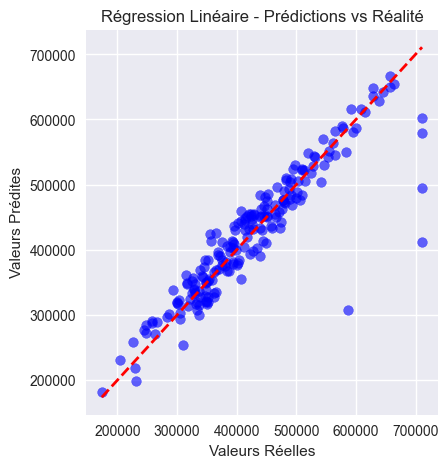

LR Coefficients: [ 79108.96  30007.7    3407.89 -22886.73  64716.09   7409.8  -24687.94
   3912.47  16634.74  16188.8    3833.84   -449.66  29990.28  -2112.33
   4670.48   -399.15  -3661.25 -11544.5    9685.4   10010.88  -5563.71
 -72108.28  13787.96  19305.28]

LR Intercept: 433362.81

 Différence entre les valeurs réelles et prédites : 
          Y val  Y_pred LR
726  417565.73  451983.69
138  541146.56  504866.48
266  608543.04  615906.48
765  316743.37  347544.80
798  451144.50  450574.21


2. Ridge Regression...


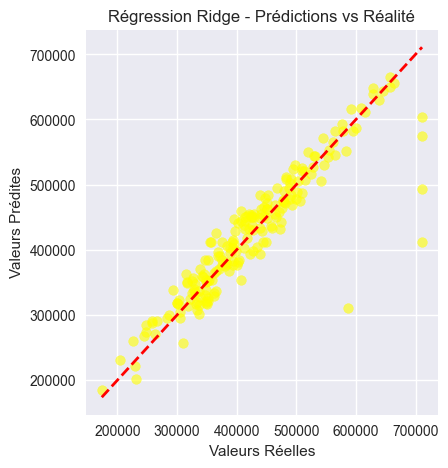


Ridge Coefficients: [ 69593.71  29037.82   6678.36 -20840.02  18300.37    113.91     80.03
   8957.2   16439.04  15877.37   5034.72  -1724.6    4498.36  -1691.8
   4707.98   -516.72  -4167.27  -6317.04   7440.89  12390.04  -5229.89
 -25052.98  17258.7   18025.53]

Ridge Intercept:  433362.81

 Différence entre les valeurs réelles et prédites : 
          Y val  Y_pred Ridge
726  417565.73     451553.45
138  541146.56     505032.19
266  608543.04     617367.07
765  316743.37     350193.55
798  451144.50     449505.09


3. Lasso Regression...


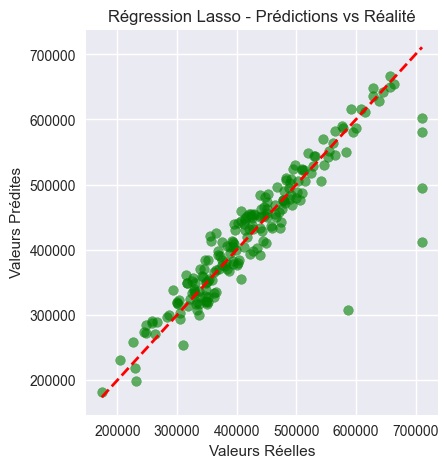


Lasso Coefficients: [ 78613.95  30090.17   3649.29 -22845.24  49653.98   5021.75   -386.9
   8936.12  16586.25  16155.65   3911.1    -393.91   5075.38  -1643.14
   5181.99     -0.    -3490.38 -11163.06   9372.05  10126.81  -5527.31
 -56868.5   13923.69  19422.66]

Lasso Intercept:  433362.81

 Différence entre les valeurs réelles et prédites : 
          Y val  Y_pred Lasso
726  417565.73     452020.03
138  541146.56     505071.50
266  608543.04     616045.19
765  316743.37     348489.76
798  451144.50     450443.22


4. Elastic Net...


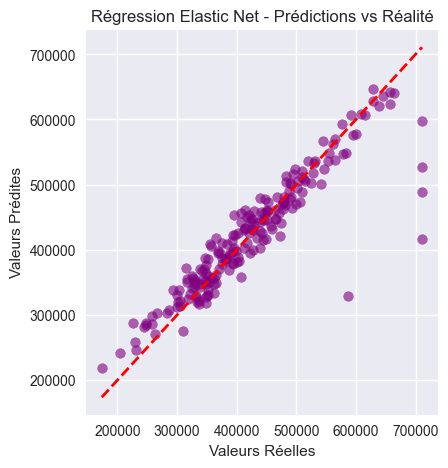

\Elastic Net Coefficients: [28915.55 10787.58  4307.01 -3065.65 -2490.26 -2744.56  1353.72  7351.23
  8515.99  5125.65 10296.73 -3570.39  2840.67  -488.04  2223.85   -75.57
 -2653.96 22118.86  8634.24 14974.6   6718.08 -3259.93 26938.49  -439.01]
\Elastic Net Intercept:  433362.81

 Différence entre les valeurs réelles et prédites : 
          Y val  Y_pred Elastic Net
726  417565.73           450392.90
138  541146.56           501473.74
266  608543.04           608515.23
765  316743.37           355196.47
798  451144.50           445757.44


5. Régression Polynomiale...


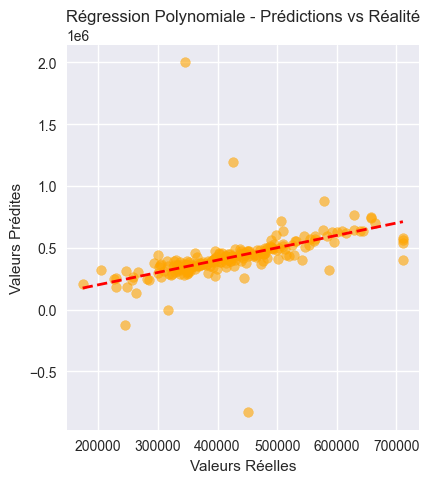

\Polynomial Reg Coefficients: [-0.00000000e+00 -2.60719860e+05  3.84372000e+03 -1.08523530e+05
 -8.56496400e+04  8.75464832e+06  1.45376638e+06  1.79225500e+05
  4.83098000e+04 -1.58599720e+05 -3.90216660e+05  7.48509900e+04
  2.04816910e+05 -1.78850820e+05 -4.20499400e+04  1.58739100e+04
 -8.29355000e+03  4.79639300e+04  2.27968140e+05  2.21886500e+05
  2.19732640e+05  5.14492280e+05 -8.86596938e+06 -9.44840000e+03
 -2.04679400e+04  3.57445510e+05  9.71449070e+05 -2.55209780e+05
  4.53161410e+05  2.34704900e+07  3.87888154e+06 -1.00148740e+05
  1.17489200e+04  5.94307140e+05  9.07880420e+05 -6.70246800e+05
  4.71196800e+05  8.10799400e+04  4.40550400e+04 -5.87370600e+04
  5.56311000e+03  1.98462000e+04 -7.44388190e+05 -3.38520490e+05
  6.19275050e+05 -1.15991054e+06 -2.38175368e+07 -1.28321880e+05
 -4.46071280e+05  9.23128300e+04 -5.15468750e+05 -1.06527630e+05
  2.92740022e+06  4.88920990e+05 -4.42771340e+05 -7.36433700e+04
 -2.23850680e+05 -3.46886790e+05 -3.03440850e+05  4.32937750

In [ ]:
print("\n🤖 MODÉLISATION")
print("="*60)


# 1. Régression Linéaire Simple
print("\n1. Régression Linéaire Simple...")

model_reg_lin_1 = LinearRegression()
model_reg_lin_1.fit(X_train_scaled, y_train)
y_pred_reg_lin_1 = model_reg_lin_1.predict(X_val_scaled)

# plot des resultats
plot_predictions_corrected(y_val, y_pred_reg_lin_1, "Régression Linéaire", 'blue')
print("LR Coefficients:", model_reg_lin_1.coef_.round(2))  # Afficher les coefficients arrondis à 2 décimales
print("\nLR Intercept:", model_reg_lin_1.intercept_.round(2))  # Afficher l'intercept arrondi à 2 décimales
print_values(y_pred_reg_lin_1, "Y_pred LR")


# 2. Ridge Regression
print("\n\n2. Ridge Regression...")

model_ridge_reg_1 = Ridge(alpha=1.0)
model_ridge_reg_1.fit(X_train_scaled, y_train)
y_pred_ridge_1 = model_ridge_reg_1.predict(X_val_scaled)

# plot des resultats
plot_predictions_corrected(y_val, y_pred_ridge_1, "Régression Ridge", 'yellow')
print("\nRidge Coefficients:", model_ridge_reg_1.coef_.round(2))
print("\nRidge Intercept: ", model_ridge_reg_1.intercept_.round(2))
print_values(y_pred_ridge_1, "Y_pred Ridge")


# 3. Lasso Regression
print("\n\n3. Lasso Regression...")

model_lasso_reg_1 = Lasso(alpha=0.1)
model_lasso_reg_1.fit(X_train_scaled, y_train)
y_pred_lasso_1 = model_lasso_reg_1.predict(X_val_scaled)

# plot des resultats
plot_predictions_corrected(y_val, y_pred_lasso_1, "Régression Lasso", 'green')
print("\nLasso Coefficients:", model_lasso_reg_1.coef_.round(2))
print("\nLasso Intercept: ", model_lasso_reg_1.intercept_.round(2))
print_values(y_pred_lasso_1, "Y_pred Lasso")



# 4. Elastic Net
print("\n\n4. Elastic Net...")

model_elasticNet_1 = ElasticNet(alpha=0.5, l1_ratio=0.5) # l1_ratio=1 => Lasso, l1_ratio=0 => Ridge
model_elasticNet_1.fit(X_train_scaled, y_train)
y_pred_elasticNet = model_elasticNet_1.predict(X_val_scaled)

# plot des resultats
plot_predictions_corrected(y_val, y_pred_elasticNet, "Régression Elastic Net", 'purple')
print("\Elastic Net Coefficients:", model_elasticNet_1.coef_.round(2))
print("\Elastic Net Intercept: ", model_elasticNet_1.intercept_.round(2))
print_values(y_pred_elasticNet, "Y_pred Elastic Net")




# 5. Régression Polynomiale (degré 2)
print("\n\n5. Régression Polynomiale...")

poly_1 = PolynomialFeatures(degree=2)
X_train_poly_1 = poly_1.fit_transform(X_train_scaled)
X_val_poly_1 = poly_1.transform(X_val_scaled) 

model_reg_poly_1 = LinearRegression().fit(X_train_poly_1, y_train)
y_pred_poly_1 = model_reg_poly_1.predict(X_val_poly_1)

# plot des resultats
plot_predictions_corrected(y_val, y_pred_poly_1, "Régression Polynomiale", 'orange')
print("\Polynomial Reg Coefficients:", model_reg_poly_1.coef_.round(2))
print("\Polynomial Reg Intercept: ", model_reg_poly_1.intercept_.round(2))
print_values(y_pred_poly_1, "Y_pred Polynomial Reg")

##### Deuxième approche en utilisant un Pipeline (pour plus de lisibilité (Facile à réutiliser et à déployer))

1.  Régression Linéaire Simple

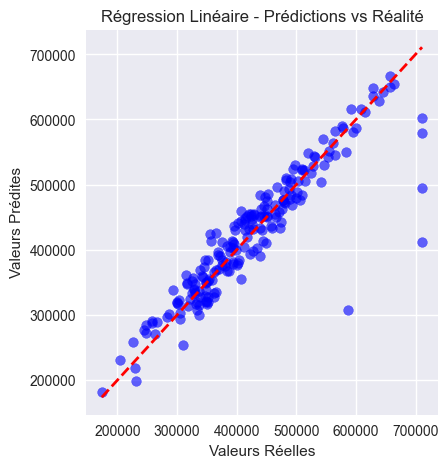


 Différence entre les valeurs réelles et prédites : 
          Y val  Y_pred LR
726  417565.73  451983.69
138  541146.56  504866.48
266  608543.04  615906.48
765  316743.37  347544.80
798  451144.50  450574.21


In [ ]:
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', LinearRegression())
])

# Entraînement
pipeline_lr.fit(X_train, y_train)
y_pred_lr = pipeline_lr.predict(X_val)

# plot des resultats
plot_predictions_corrected(y_val, y_pred_lr, "Régression Linéaire", 'blue')
print_values(y_pred_lr, "Y_pred LR")

2.  Ridge Regression 

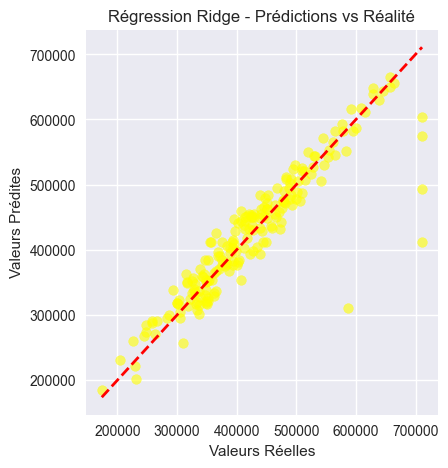


 Différence entre les valeurs réelles et prédites : 
          Y val  Y_pred Ridge
726  417565.73     451553.45
138  541146.56     505032.19
266  608543.04     617367.07
765  316743.37     350193.55
798  451144.50     449505.09


In [21]:
pipeline_ridge = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', Ridge(alpha=1.0))
])

# Entraînement
pipeline_ridge.fit(X_train, y_train)
y_pred_ridge = pipeline_ridge.predict(X_val)

# plot des resultats
plot_predictions_corrected(y_val, y_pred_ridge, "Régression Ridge", 'yellow')
print_values(y_pred_ridge, "Y_pred Ridge")

3.  Lasso Regression

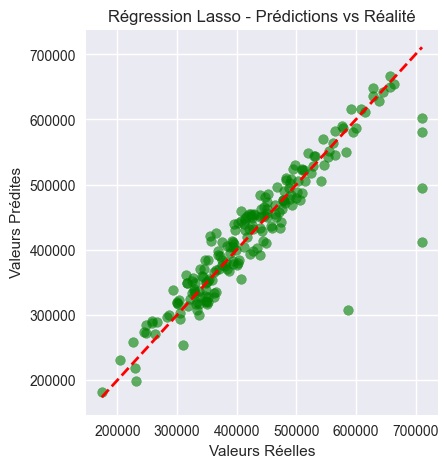


 Différence entre les valeurs réelles et prédites : 
          Y val  Y_pred Lasso
726  417565.73     452020.03
138  541146.56     505071.50
266  608543.04     616045.19
765  316743.37     348489.76
798  451144.50     450443.22


In [22]:
pipeline_lasso = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', Lasso(alpha=0.1))
])

# Entraînement
pipeline_lasso.fit(X_train, y_train)
y_pred_lasso = pipeline_lasso.predict(X_val)

# plot des resultats
plot_predictions_corrected(y_val, y_pred_lasso, "Régression Lasso", 'green')
print_values(y_pred_lasso, "Y_pred Lasso")

4.  Elastic Net Regression

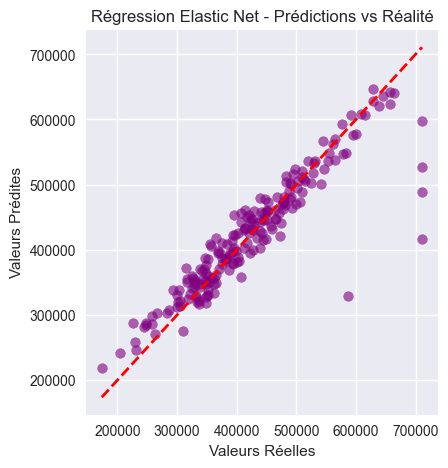


 Différence entre les valeurs réelles et prédites : 
          Y val  Y_pred Elastic Net
726  417565.73           450392.90
138  541146.56           501473.74
266  608543.04           608515.23
765  316743.37           355196.47
798  451144.50           445757.44


In [23]:
pipeline_elastic = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', ElasticNet(alpha=0.5, l1_ratio=0.5))
])

# Entraînement
pipeline_elastic.fit(X_train, y_train)
y_pred_elastic = pipeline_elastic.predict(X_val)

# plot des resultats
plot_predictions_corrected(y_val, y_pred_elastic, "Régression Elastic Net", 'purple')
print_values(y_pred_elastic, "Y_pred Elastic Net")

5. Polynomial Regression

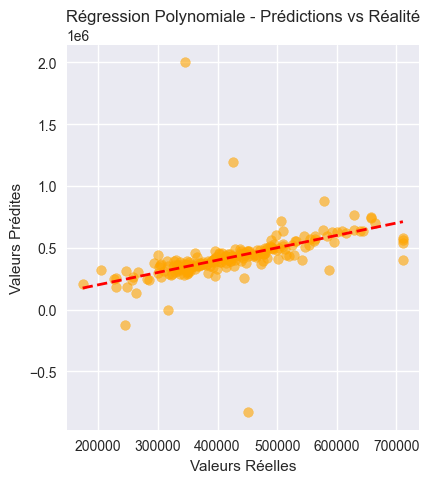


 Différence entre les valeurs réelles et prédites : 
          Y val  Y_pred Polynomial Reg
726  417565.73              450276.80
138  541146.56              401360.66
266  608543.04              637693.63
765  316743.37                -154.46
798  451144.50              433633.92


In [24]:
pipeline_poly = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('reg', LinearRegression())
])

# Entrainement
pipeline_poly.fit(X_train, y_train)
y_pred_poly = pipeline_poly.predict(X_val)

# plot des resultats
plot_predictions_corrected(y_val, y_pred_poly, "Régression Polynomiale", 'orange')
print_values(y_pred_poly, "Y_pred Polynomial Reg")

### ÉVALUATION ET COMPARAISON

In [25]:
# Fonction pour calculer toutes les métriques
def evaluer_modele(y_true, y_pred, nom_modele):
    """
    Calcule toutes les métriques d'évaluation
    """
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    return {
        'Modèle': nom_modele,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'MAPE (%)': mape
    }

# Correction - BUG 4: Division par zéro dans MAPE
def evaluer_modele_corrected(y_true, y_pred, nom_modele):
    """Version corrigée sans division par zéro"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # CORRECTION: Éviter division par zéro dans MAPE
    mask = y_true != 0
    if mask.sum() > 0:
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    else:
        mape = np.inf

    # ou bien 
    # mape = np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-8))) * 100    
    
    return {
        'Modèle': nom_modele,
        'MSE': round(mse, 2),
        'RMSE': round(rmse, 2),
        'MAE': round(mae, 2),
        'R²': round(r2, 4),
        'MAPE (%)': round(mape, 2)
    }

In [ ]:
print("\n📈 ÉVALUATION DES MODÈLES")
print("="*60)


# Évaluation de chaque modèle

# Dictionnaire pour stocker les résultats 
resultats = {}


resultats["Régression Linéaire"] = evaluer_modele_corrected(y_val, y_pred_lr, "Régression Linéaire")
resultats["Ridge"] = evaluer_modele_corrected(y_val, y_pred_ridge, "Ridge")
resultats["Lasso"] = evaluer_modele_corrected(y_val, y_pred_lasso, "Lasso")
resultats["Elastic Net"] = evaluer_modele_corrected(y_val, y_pred_elastic, "Elastic Net")
resultats["Régression Polynomiale"] = evaluer_modele_corrected(y_val, y_pred_poly, "Régression Polynomiale")

print("\n\nAffichage de l'évaluation de chaque modèle :\n")
for i in resultats :
    print(resultats[i])



# Création du tableau de comparaison

df_results = pd.DataFrame(resultats)
df_results = df_results.T.drop(columns="Modèle")
print("\n\nTableau comparatif des performances des modèles :")
display(df_results.style.highlight_min(subset=["MSE", "RMSE", "MAE", "MAPE (%)"], color='green')
                        .highlight_max(subset=["R²"], color='red'))


📈 ÉVALUATION DES MODÈLES


Affichage de l'évaluation de chaque modèle :

{'Modèle': 'Régression Linéaire', 'MSE': 1767793062.38, 'RMSE': np.float64(42045.13), 'MAE': 24318.15, 'R²': 0.8395, 'MAPE (%)': np.float64(5.77)}
{'Modèle': 'Ridge', 'MSE': 1754390583.76, 'RMSE': np.float64(41885.45), 'MAE': 24129.45, 'R²': 0.8407, 'MAPE (%)': np.float64(5.71)}
{'Modèle': 'Lasso', 'MSE': 1762513837.07, 'RMSE': np.float64(41982.3), 'MAE': 24277.86, 'R²': 0.84, 'MAPE (%)': np.float64(5.76)}
{'Modèle': 'Elastic Net', 'MSE': 1804780919.44, 'RMSE': np.float64(42482.71), 'MAE': 24532.39, 'R²': 0.8361, 'MAPE (%)': np.float64(5.93)}
{'Modèle': 'Régression Polynomiale', 'MSE': 30074317655.58, 'RMSE': np.float64(173419.48), 'MAE': 62835.48, 'R²': -1.7304, 'MAPE (%)': np.float64(15.74)}


Tableau comparatif des performances des modèles :


,MSE,RMSE,MAE,R²,MAPE (%)
Régression Linéaire,1767793062.380000,42045.130000,24318.150000,0.839500,5.770000
Ridge,1754390583.760000,41885.450000,24129.450000,0.840700,5.710000
Lasso,1762513837.070000,41982.300000,24277.860000,0.840000,5.760000
Elastic Net,1804780919.440000,42482.710000,24532.390000,0.836100,5.930000
Régression Polynomiale,30074317655.580002,173419.480000,62835.480000,-1.730400,15.740000


##### GridSearchCV pour trouver les meilleurs hyperparamètres et les utiliser

In [27]:
# Pipeline Ridge
pipeline_ridge_gscv = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

# Grille de recherche
param_grid_ridge_gscv = {
    'ridge__alpha': [0.01, 0.1, 1, 10, 100]
}

# GridSearch
grid_ridge_gscv = GridSearchCV(pipeline_ridge_gscv, param_grid_ridge_gscv, cv=5, scoring='neg_mean_squared_error')
grid_ridge_gscv.fit(X_train, y_train)

# Meilleur modèle
best_ridge_gscv = grid_ridge_gscv.best_estimator_
y_pred_best_ridge_gscv = best_ridge_gscv.predict(X_val)

# Évaluation
resultats["Ridge (GridSearch)"] = evaluer_modele_corrected(y_val, y_pred_best_ridge_gscv, "Ridge (GridSearch)")

print("🔍 Meilleur alpha Ridge :", grid_ridge_gscv.best_params_['ridge__alpha'])



# LASSO 
pipeline_lasso_gscv = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso(max_iter=10000))
])

param_grid_lasso_gscv = {
    'lasso__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

grid_lasso_gscv = GridSearchCV(pipeline_lasso_gscv, param_grid_lasso_gscv, cv=5, scoring='neg_mean_squared_error')
grid_lasso_gscv.fit(X_train, y_train)

best_lasso_gscv = grid_lasso_gscv.best_estimator_
y_pred_best_lasso_gscv = best_lasso_gscv.predict(X_val)

resultats["Lasso (GridSearch)"] = evaluer_modele_corrected(y_val, y_pred_best_lasso_gscv, "Lasso (GridSearch)")
print("🔍 Meilleur alpha Lasso :", grid_lasso_gscv.best_params_['lasso__alpha'])



# ElasticNet
pipeline_elastic_gscv = Pipeline([
    ('scaler', StandardScaler()),
    ('elastic', ElasticNet(max_iter=10000))
])

param_grid_elastic_gscv = {
    'elastic__alpha': [0.001, 0.01, 0.1, 1, 10],
    'elastic__l1_ratio': [0.2, 0.5, 0.7, 0.9]
}

grid_elastic_gscv = GridSearchCV(pipeline_elastic_gscv, param_grid_elastic_gscv, cv=5, scoring='neg_mean_squared_error')
grid_elastic_gscv.fit(X_train, y_train)

best_elastic_gscv = grid_elastic_gscv.best_estimator_
y_pred_best_elastic_gscv = best_elastic_gscv.predict(X_val)

resultats["ElasticNet (GridSearch)"] = evaluer_modele_corrected(y_val, y_pred_best_elastic_gscv, "ElasticNet (GridSearch)")
print("🔍 Meilleurs paramètres ElasticNet :", grid_elastic_gscv.best_params_)



# Polynomial Regression
pipeline_poly_gscv = Pipeline([
    ('scaler', StandardScaler()),
    ('poly_features', PolynomialFeatures(degree=2, include_bias=False)),
    ('reg', LinearRegression())
])

param_grid_poly_gscv = {
    'poly_features__degree': [2, 3, 4]
}

grid_poly_gscv = GridSearchCV(pipeline_poly_gscv, param_grid_poly_gscv, cv=5, scoring='neg_mean_squared_error')
grid_poly_gscv.fit(X_train, y_train)

best_poly_gscv = grid_poly_gscv.best_estimator_
y_pred_best_poly_gscv = best_poly_gscv.predict(X_val)

resultats["Polynomial (GridSearch)"] = evaluer_modele_corrected(y_val, y_pred_best_poly_gscv, "Polynomial (GridSearch)")
print("🔍 Meilleurs paramètres Polynomial :", grid_poly_gscv.best_params_)

🔍 Meilleur alpha Ridge : 10
🔍 Meilleur alpha Lasso : 1000
🔍 Meilleurs paramètres ElasticNet : {'elastic__alpha': 0.1, 'elastic__l1_ratio': 0.7}
🔍 Meilleurs paramètres Polynomial : {'poly_features__degree': 4}


Autre approche optimisée

In [28]:
# Dictionnaire des modèles
models = {
    'Ridge': Ridge(max_iter=10000),
    'Lasso': Lasso(max_iter=10000),
    'Elastic Net': ElasticNet(),
    'Régression Linéaire': LinearRegression(),
    'Régression Polynomiale': Pipeline([
        ('poly_features', PolynomialFeatures(degree=2, include_bias=False)),
        ('scaler', StandardScaler()),
        ('reg', LinearRegression())
    ])
}

# Grilles d'hyperparamètres
param_grids = {
    'Régression Linéaire': {},  # pas d'hyperparamètre
    'Ridge': {'reg__alpha': [0.01, 0.1, 1, 10, 100]},
    'Lasso': {'reg__alpha': [0.01, 0.1, 1, 10, 100]},
    'Elastic Net': {
        'reg__alpha': [0.01, 0.1, 1, 10],
        'reg__l1_ratio': [0.2, 0.5, 0.8]
    },
    'Régression Polynomiale': {
        'poly_features__degree': [2, 3, 4]
    }
}

# Lancer le GridSearchCV pour chaque modèle
best_models = {}
for name, model in models.items():
    print(f"\n🔍 GridSearchCV pour {name}")
    
    if name == 'Régression Polynomiale':
        grid = GridSearchCV(
            model,
            param_grids[name],
            cv=5,
            scoring='neg_mean_squared_error',
            n_jobs=-1
        )
    else:
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('reg', model)
        ])
        grid = GridSearchCV(
            pipeline,
            param_grids[name],
            cv=5,
            scoring='neg_mean_squared_error',
            n_jobs=-1
        )
    
    grid.fit(X_train, y_train)
    best_models[name] = {
        'best_estimator': grid.best_estimator_,
        'best_params': grid.best_params_,
        'best_score': -grid.best_score_  # car on a utilisé neg_mean_squared_error
    }
    print("✔️ Meilleur score MSE (CV):", round(-grid.best_score_, 2))
    print("✔️ Meilleurs paramètres:", grid.best_params_)


df_resultats = pd.DataFrame([
    {
        'Modèle': name,
        'Meilleur Score MSE (CV)': data['best_score'],
        'Meilleurs Paramètres': data['best_params']
    }
    for name, data in best_models.items()
])

df_resultats = df_resultats.sort_values(by="Meilleur Score MSE (CV)")
print("\n📈 Résumé des performances :")
df_resultats.style.highlight_min(subset=["Meilleur Score MSE (CV)"], color='red')


🔍 GridSearchCV pour Ridge
✔️ Meilleur score MSE (CV): 1875068061.61
✔️ Meilleurs paramètres: {'reg__alpha': 10}

🔍 GridSearchCV pour Lasso


/Users/awaseck/Projets/0_renforcement_competences/ML_Projects/ml_env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.316e+11, tolerance: 5.927e+08
  model = cd_fast.enet_coordinate_descent(
/Users/awaseck/Projets/0_renforcement_competences/ML_Projects/ml_env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.146e+11, tolerance: 5.946e+08
  model = cd_fast.enet_coordinate_descent(
/Users/awaseck/Projets/0_renforcement_competences/ML_Projects/ml_env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not c

✔️ Meilleur score MSE (CV): 1875814764.93
✔️ Meilleurs paramètres: {'reg__alpha': 100}

🔍 GridSearchCV pour Elastic Net
✔️ Meilleur score MSE (CV): 1875032361.95
✔️ Meilleurs paramètres: {'reg__alpha': 0.1, 'reg__l1_ratio': 0.8}

🔍 GridSearchCV pour Régression Linéaire
✔️ Meilleur score MSE (CV): 1903017186.91
✔️ Meilleurs paramètres: {}

🔍 GridSearchCV pour Régression Polynomiale


/Users/awaseck/Projets/0_renforcement_competences/ML_Projects/ml_env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.698e+10, tolerance: 5.927e+08
  model = cd_fast.enet_coordinate_descent(
/Users/awaseck/Projets/0_renforcement_competences/ML_Projects/ml_env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.248e+10, tolerance: 5.484e+08
  model = cd_fast.enet_coordinate_descent(
/Users/awaseck/Projets/0_renforcement_competences/ML_Projects/ml_env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not c

✔️ Meilleur score MSE (CV): 14376333590.37
✔️ Meilleurs paramètres: {'poly_features__degree': 4}

📈 Résumé des performances :


,Modèle,Meilleur Score MSE (CV),Meilleurs Paramètres
2,Elastic Net,1875032361.948913,"{'reg__alpha': 0.1, 'reg__l1_ratio': 0.8}"
0,Ridge,1875068061.608818,{'reg__alpha': 10}
1,Lasso,1875814764.926928,{'reg__alpha': 100}
3,Régression Linéaire,1903017186.914170,{}
4,Régression Polynomiale,14376333590.367619,{'poly_features__degree': 4}


### MODÉLISATION ET ÉVALUATION - VERSION OPTIMISÉE


🤖 MODÉLISATION OPTIMISÉE

🔄 Entraînement Linear Regression...

🔄 Entraînement Ridge...

🔄 Entraînement Lasso...

🔄 Entraînement ElasticNet...

🔄 Entraînement Polynomial (degree=2)...

📊 RÉSULTATS DÉTAILLÉS

Tableau comparatif des performances:
                                      MSE       RMSE       MAE      R²  \
Linear Regression           1767793062.38   42045.13  24318.15  0.8395   
Ridge                       1754390583.76   41885.45  24129.45  0.8407   
Lasso                       1767674709.58   42043.72  24317.22  0.8395   
ElasticNet                  1804780919.44   42482.71  24532.39  0.8361   
Polynomial (degree=2)  31323951164.790001  176985.74  64174.89 -1.8439   

                      MAPE (%)    CV_RMSE CV_RMSE_std  
Linear Regression         5.77   43623.59    27413.98  
Ridge                     5.71   43411.16    27616.37  
Lasso                     5.77   43619.39    27412.68  
ElasticNet                5.93   43943.14    27044.86  
Polynomial (degree=2)    16.03

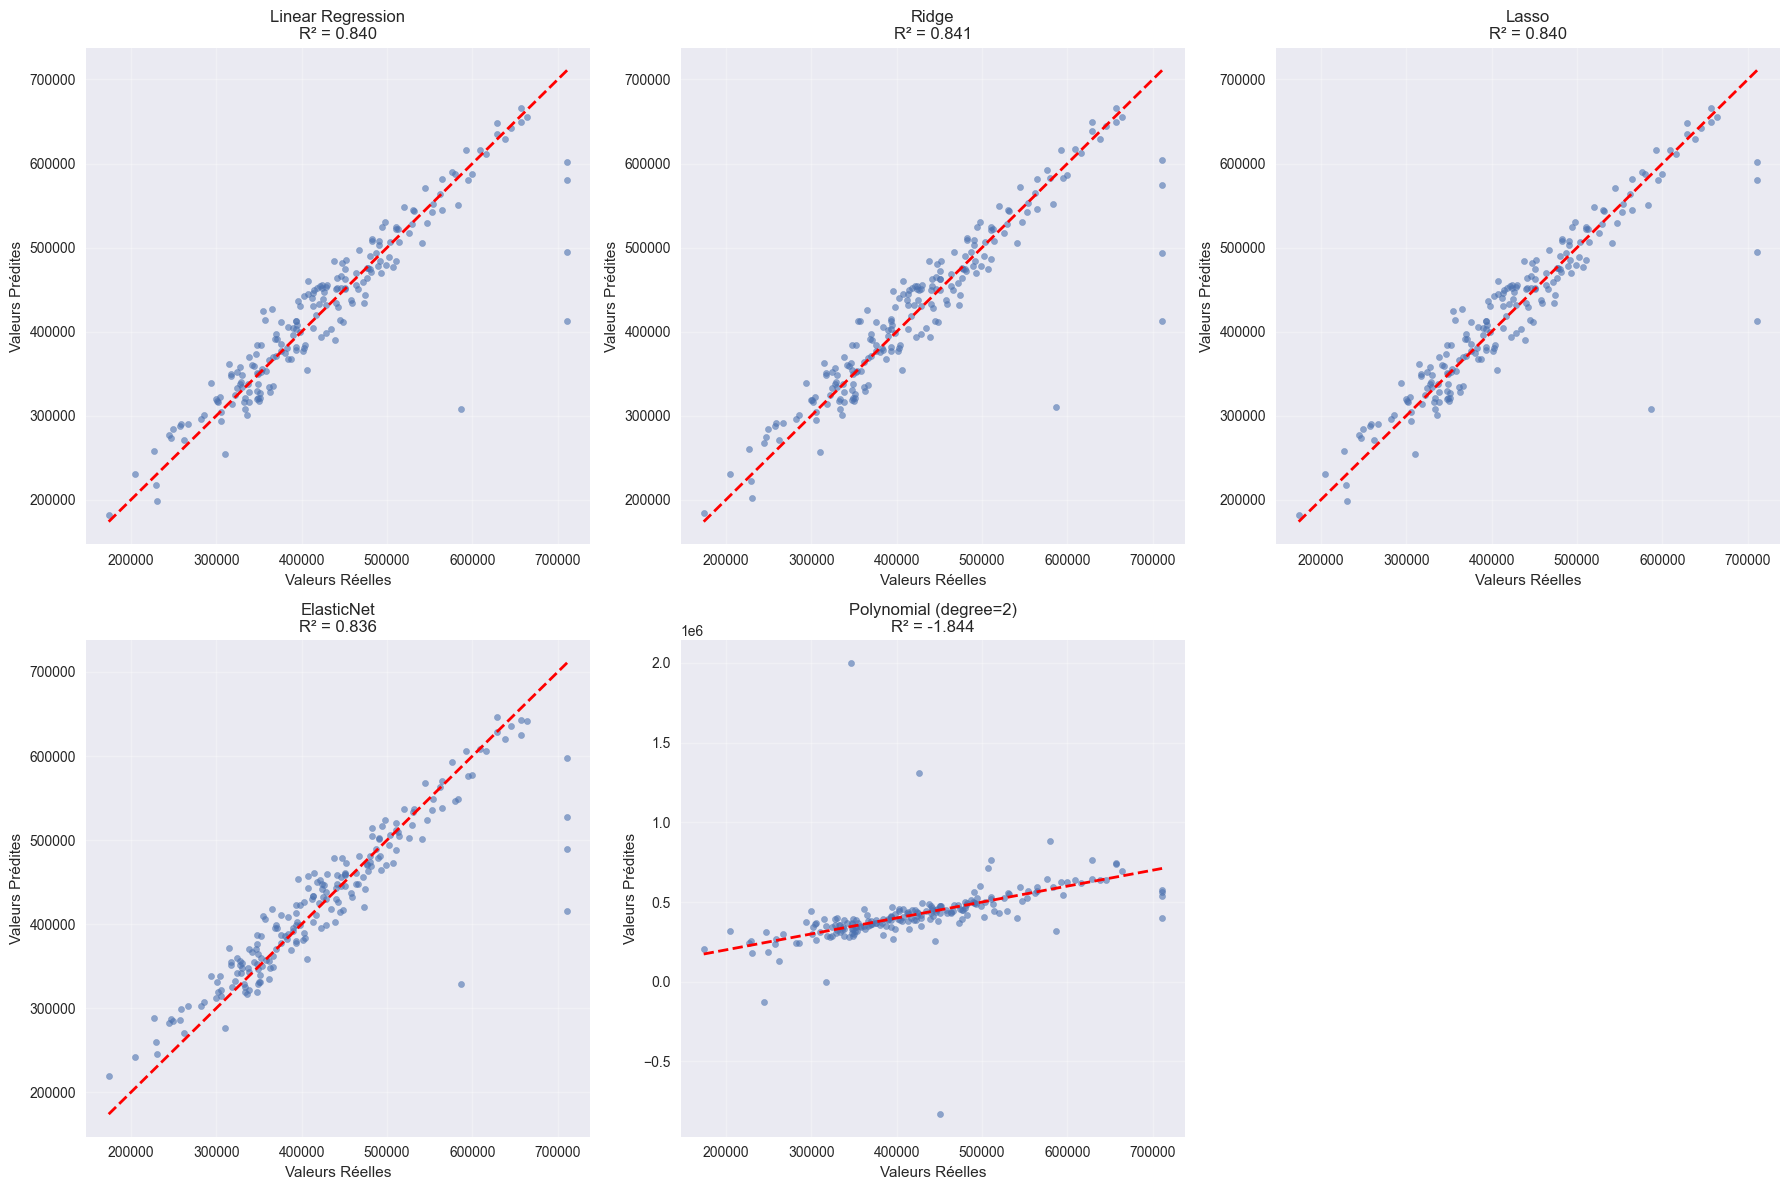

In [ ]:
print("\n🤖 MODÉLISATION OPTIMISÉE")
print("="*60)

# Utilisation des Pipelines (approche propre et reproductible)

# Définition des modèles avec pipelines
models_2 = {
    'Linear Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('reg', LinearRegression())
    ]),
    'Ridge': Pipeline([
        ('scaler', StandardScaler()),
        ('reg', Ridge(alpha=1.0))
    ]),
    'Lasso': Pipeline([
        ('scaler', StandardScaler()),
        ('reg', Lasso(alpha=0.1, max_iter=10000))
    ]),
    'ElasticNet': Pipeline([
        ('scaler', StandardScaler()),
        ('reg', ElasticNet(alpha=0.5, l1_ratio=0.5, max_iter=10000))
    ]),
    'Polynomial (degree=2)': Pipeline([
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('scaler', StandardScaler()),
        ('reg', LinearRegression())
    ])
}

# Entraînement et évaluation
resultats_2 = {}
predictions_2 = {}

for name, model in models_2.items():
    print(f"\n🔄 Entraînement {name}...")
    
    # Entraînement
    model.fit(X_train, y_train)
    
    # Prédictions
    y_pred = model.predict(X_val)
    predictions_2[name] = y_pred
    
    # Évaluation
    resultats_2[name] = evaluer_modele_corrected(y_val, y_pred, name)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, 
                               scoring='neg_mean_squared_error')
    
    resultats_2[name]['CV_RMSE'] = round(np.sqrt(-cv_scores.mean()), 2)
    resultats_2[name]['CV_RMSE_std'] = round(np.sqrt(cv_scores.std()), 2)

# Affichage des résultats
print("\n📊 RÉSULTATS DÉTAILLÉS")
print("="*60)

df_results_2 = pd.DataFrame(resultats_2).T.drop(columns='Modèle')
print("\nTableau comparatif des performances:")
print(df_results_2.round(3))

# Identification du meilleur modèle
best_model_name_2 = df_results_2['R²'].idxmax()
print(f"\n🏆 MEILLEUR MODÈLE: {best_model_name_2}")
print(f"   R² = {df_results_2.loc[best_model_name_2, 'R²']:.4f}")
print(f"   RMSE = {df_results.loc[best_model_name_2, 'RMSE']:.2f}")

# Visualisations comparatives
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, (name, y_pred) in enumerate(predictions_2.items()):
    if i < len(axes):
        axes[i].scatter(y_val, y_pred, alpha=0.6, s=20)
        axes[i].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
        axes[i].set_xlabel('Valeurs Réelles')
        axes[i].set_ylabel('Valeurs Prédites')
        axes[i].set_title(f'{name}\nR² = {resultats_2[name]["R²"]:.3f}')
        axes[i].grid(True, alpha=0.3)

# Supprimer le subplot vide si nécessaire
if len(predictions_2) < len(axes):
    axes[-1].remove()

plt.tight_layout()
plt.show()

In [30]:
# OPTIMISATION DES HYPERPARAMÈTRES
print("\n🔍 OPTIMISATION DES HYPERPARAMÈTRES")
print("="*60)

# Grilles de paramètres optimisées
param_grids_2 = {
    'Ridge': {
        'reg__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    },
    'Lasso': {
        'reg__alpha': [0.001, 0.01, 0.1, 1, 10, 100]
    },
    'ElasticNet': {
        'reg__alpha': [0.001, 0.01, 0.1, 1, 10],
        'reg__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
    }

}

# Optimisation
best_models_2 = {}
best_estimators_2 = {}  # Store the actual trained models

for name in ['Ridge', 'Lasso', 'ElasticNet']:
    print(f"\n🔍 Optimisation {name}...")
    
    grid_2 = GridSearchCV(
        models_2[name], 
        param_grids_2[name], 
        cv=5, 
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    
    grid_2.fit(X_train, y_train)

    # Store the best estimator
    model_name = f'{name}_optimized'
    best_estimators_2[model_name] = grid_2.best_estimator_
    
    # Évaluation du meilleur modèle
    y_pred_best_2 = grid_2.predict(X_val)
    best_models_2[model_name] = evaluer_modele_corrected(y_val, y_pred_best_2, model_name)
    
    print(f"✅ Meilleurs paramètres pour {name} : {grid_2.best_params_}")
    print(f"✅ RMSE CV pour {name} : {np.sqrt(-grid_2.best_score_):.2f}\n")

# Comparaison finale
print("\n COMPARAISON FINALE")
print("="*60)

# Combiner tous les résultats
all_results_2 = {**resultats_2, **best_models_2}
df_final_2 = pd.DataFrame(all_results_2).T.drop(columns='Modèle')

# Trier par R²
df_final_sorted_2 = df_final_2.sort_values('R²', ascending=False)
print("\nClassement final (par R²):")
print(df_final_sorted_2[['R²', 'RMSE', 'MAE', 'MAPE (%)']].round(4))

final_best = df_final_sorted_2.index[0]
print(f"\n🎯 MODÈLE FINAL RECOMMANDÉ: {final_best}")
print(f"   Performance: R² = {df_final_sorted_2.loc[final_best, 'R²']:.4f}")


🔍 OPTIMISATION DES HYPERPARAMÈTRES

🔍 Optimisation Ridge...
✅ Meilleurs paramètres pour Ridge : {'reg__alpha': 10}
✅ RMSE CV pour Ridge : 43302.06


🔍 Optimisation Lasso...


/Users/awaseck/Projets/0_renforcement_competences/ML_Projects/ml_env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.732e+11, tolerance: 5.484e+08
  model = cd_fast.enet_coordinate_descent(
/Users/awaseck/Projets/0_renforcement_competences/ML_Projects/ml_env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.392e+11, tolerance: 5.530e+08
  model = cd_fast.enet_coordinate_descent(
/Users/awaseck/Projets/0_renforcement_competences/ML_Projects/ml_env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not c

✅ Meilleurs paramètres pour Lasso : {'reg__alpha': 100}
✅ RMSE CV pour Lasso : 43310.68


🔍 Optimisation ElasticNet...


/Users/awaseck/Projets/0_renforcement_competences/ML_Projects/ml_env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.869e+09, tolerance: 5.927e+08
  model = cd_fast.enet_coordinate_descent(
/Users/awaseck/Projets/0_renforcement_competences/ML_Projects/ml_env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.657e+10, tolerance: 5.946e+08
  model = cd_fast.enet_coordinate_descent(
/Users/awaseck/Projets/0_renforcement_competences/ML_Projects/ml_env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not c

✅ Meilleurs paramètres pour ElasticNet : {'reg__alpha': 0.1, 'reg__l1_ratio': 0.7}
✅ RMSE CV pour ElasticNet : 43309.59


 COMPARAISON FINALE

Classement final (par R²):
                           R²       RMSE       MAE MAPE (%)
Lasso_optimized        0.8423   41678.85  23777.21      5.6
Ridge                  0.8407   41885.45  24129.45     5.71
Ridge_optimized        0.8407    41889.7  24007.35     5.67
ElasticNet_optimized   0.8403   41939.93  23996.91     5.66
Linear Regression      0.8395   42045.13  24318.15     5.77
Lasso                  0.8395   42043.72  24317.22     5.77
ElasticNet             0.8361   42482.71  24532.39     5.93
Polynomial (degree=2) -1.8439  176985.74  64174.89    16.03

🎯 MODÈLE FINAL RECOMMANDÉ: Lasso_optimized
   Performance: R² = 0.8423


/Users/awaseck/Projets/0_renforcement_competences/ML_Projects/ml_env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.047e+11, tolerance: 5.956e+08
  model = cd_fast.enet_coordinate_descent(
/Users/awaseck/Projets/0_renforcement_competences/ML_Projects/ml_env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.347e+11, tolerance: 5.946e+08
  model = cd_fast.enet_coordinate_descent(
/Users/awaseck/Projets/0_renforcement_competences/ML_Projects/ml_env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not c

### VISUALISATIONS DES RÉSULTATS

In [31]:
# # Liste pour stocker les résultats d'évaluation sur X_val
# val_results = []

# # Boucle sur les meilleurs modèles
# for name, data in best_models.items():
#     model = data['best_estimator']
#     y_pred = model.predict(X_val)
    
#     # Evaluer les performances
#     resultats = evaluer_modele(y_val, y_pred, nom_modele=name)
#     val_results.append(resultats)


# # Création d'un DataFrame
# df_val = pd.DataFrame(val_results)
# df_val.style.highlight_max(subset=["R²"], color='green').highlight_min(subset=["RMSE"], color='purple')

In [33]:
print("Résultats sur le jeu de validation : visualisation des scores R² et RMSE pour le meilleur model :")
display(df_final_2.style.highlight_max(subset=["R²"], color='green').highlight_min(subset=["RMSE"], color='purple'))

Résultats sur le jeu de validation : visualisation des scores R² et RMSE pour le meilleur model :


,MSE,RMSE,MAE,R²,MAPE (%),CV_RMSE,CV_RMSE_std
Linear Regression,1767793062.380000,42045.130000,24318.150000,0.839500,5.770000,43623.590000,27413.980000
Ridge,1754390583.760000,41885.450000,24129.450000,0.840700,5.710000,43411.160000,27616.370000
Lasso,1767674709.580000,42043.720000,24317.220000,0.839500,5.770000,43619.390000,27412.680000
ElasticNet,1804780919.440000,42482.710000,24532.390000,0.836100,5.930000,43943.140000,27044.860000
Polynomial (degree=2),31323951164.790001,176985.740000,64174.890000,-1.843900,16.030000,417418.210000,416971.980000
Ridge_optimized,1754747256.670000,41889.700000,24007.350000,0.840700,5.670000,nan,nan
Lasso_optimized,1737126281.230000,41678.850000,23777.210000,0.842300,5.600000,nan,nan
ElasticNet_optimized,1758957709.370000,41939.930000,23996.910000,0.840300,5.660000,nan,nan


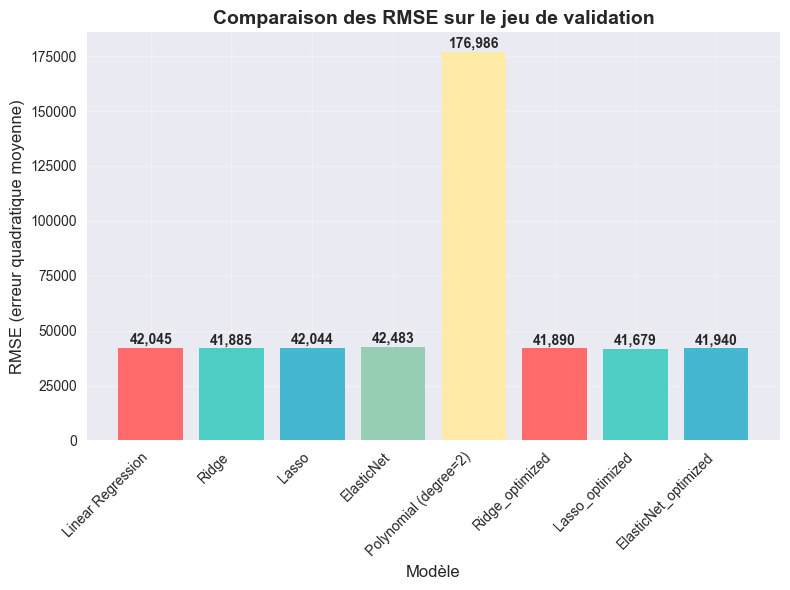

In [34]:
# GRAPHIQUES DE COMPARAISON
# 1. Comparaison RMSE
plt.figure(figsize=(8, 6))
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']
bars = plt.bar(df_final_2.index, df_final_2['RMSE'], color=colors)
plt.title("Comparaison des RMSE sur le jeu de validation", fontsize=14, fontweight='bold')
plt.xlabel("Modèle", fontsize=12)
plt.ylabel("RMSE (erreur quadratique moyenne)", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)

# Ajouter les valeurs sur les barres
for bar, value in zip(bars, df_final_2['RMSE']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 500,
             f'{value:,.0f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

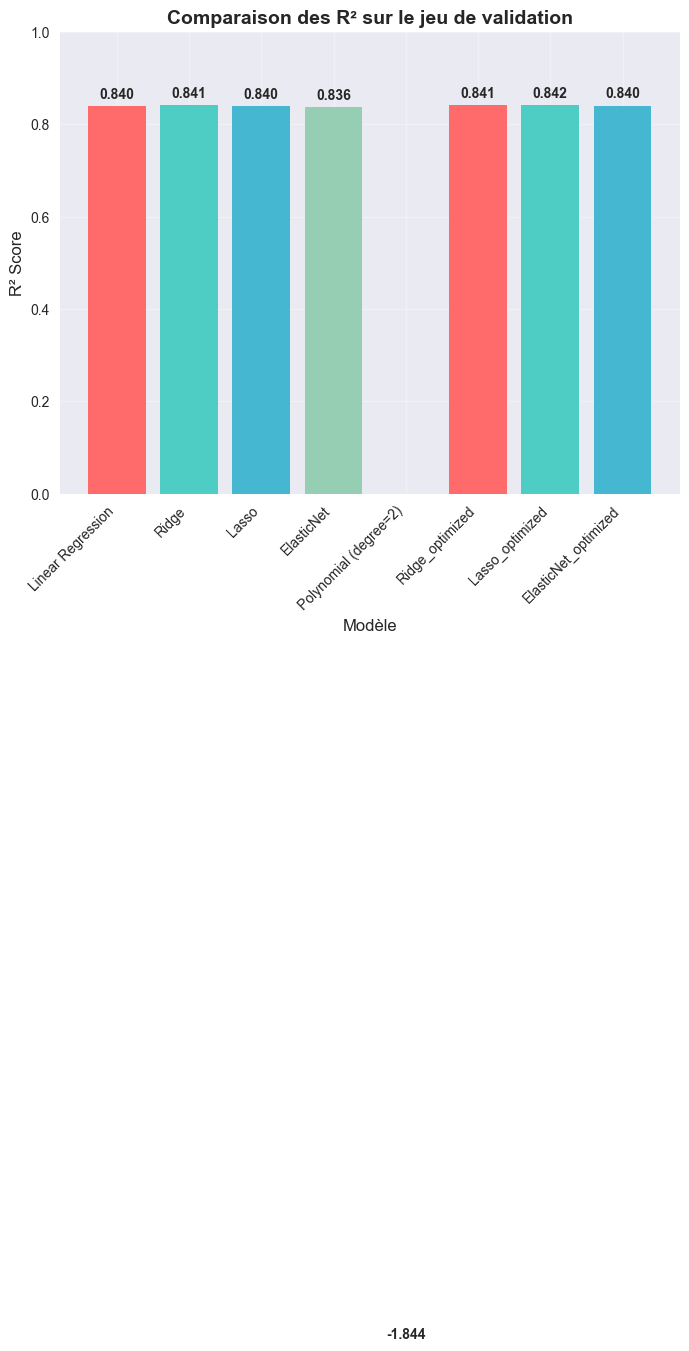

In [35]:
# 2. Comparaison R²
plt.figure(figsize=(8, 6))
bars = plt.bar(df_final_2.index, df_final_2['R²'], color=colors)
plt.title("Comparaison des R² sur le jeu de validation", fontsize=14, fontweight='bold')
plt.xlabel("Modèle", fontsize=12)
plt.ylabel("R² Score", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)

# Ajouter les valeurs sur les barres
for bar, value in zip(bars, df_final_2['R²']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

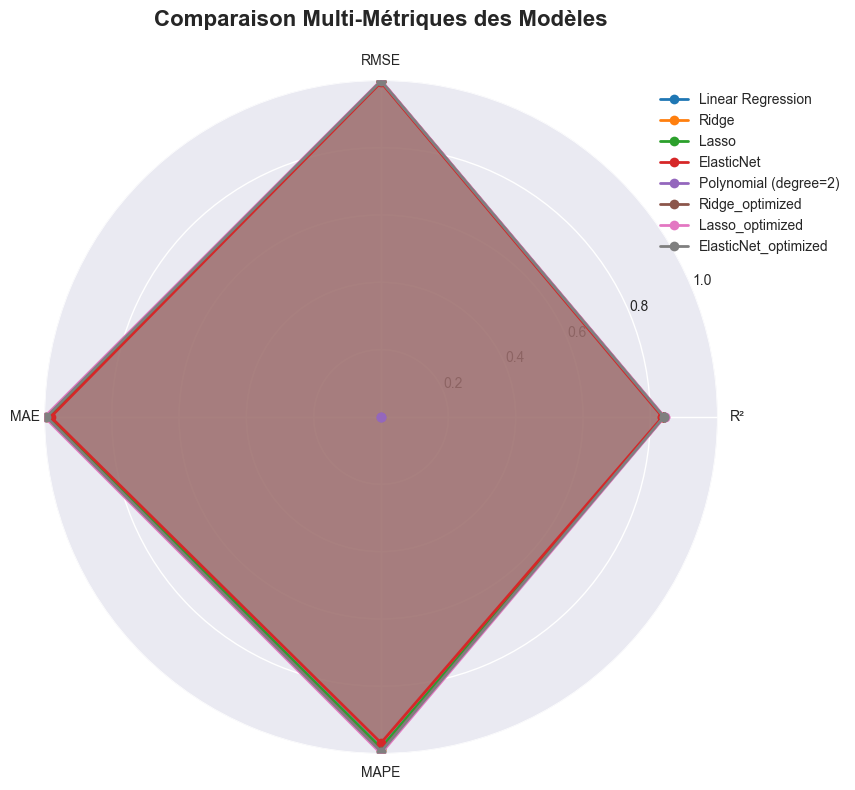

In [36]:
# 3. Graphique radar pour comparaison multi-métriques
def create_radar_chart(df_val):
    """Créer un graphique radar pour comparer les modèles"""
    from math import pi

    # Define colors for the models
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
              '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    
    # Normaliser les métriques pour le radar (plus c'est proche de 1, mieux c'est)
    df_radar = df_val.copy()

    df_radar['RMSE_norm'] = 1 - (df_radar['RMSE'] - df_radar['RMSE'].min()) / (df_radar['RMSE'].max() - df_radar['RMSE'].min())
    df_radar['MAE_norm'] = 1 - (df_radar['MAE'] - df_radar['MAE'].min()) / (df_radar['MAE'].max() - df_radar['MAE'].min())
    df_radar['MAPE_norm'] = 1 - (df_radar['MAPE (%)'] - df_radar['MAPE (%)'].min()) / (df_radar['MAPE (%)'].max() - df_radar['MAPE (%)'].min())
    
    # Métriques pour le radar
    metrics = ['R²', 'RMSE_norm', 'MAE_norm', 'MAPE_norm']
    metric_labels = ['R²', 'RMSE', 'MAE', 'MAPE']
    
    # Angles pour chaque métrique
    angles = [n / float(len(metrics)) * 2 * pi for n in range(len(metrics))]
    angles += angles[:1]  # Fermer le cercle
    
    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection='polar'))
    
    # Plot pour chaque modèle
    for i, model in enumerate(df_radar.index):
        values = df_radar.iloc[i][metrics].values.tolist()
        values += values[:1]  # Fermer le cercle
        
        ax.plot(angles, values, 'o-', linewidth=2, label=model, color=colors[i])
        ax.fill(angles, values, alpha=0.25, color=colors[i])
    
    # Personnalisation
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metric_labels)
    ax.set_ylim(0, 1)
    ax.set_title('Comparaison Multi-Métriques des Modèles', size=16, fontweight='bold', pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
    ax.grid(True)
    
    plt.tight_layout()
    plt.show()


create_radar_chart(df_final_2)

ANALYSE DES RÉSIDUS POUR LE MEILLEUR MODÈLE

In [37]:
# Récupérer le meilleur modèle
if final_best in best_estimators_2:
    best_model_z = best_estimators_2[final_best]
else:
    # Si c'est un modèle de base, utiliser le modèle original
    model_mapping = {
        'Ridge': models_2['Ridge'],
        'Lasso': models_2['Lasso'], 
        'ElasticNet': models_2['ElasticNet']
    }
    if final_best in model_mapping:
        best_model_z = model_mapping[final_best]
        # Réentraîner si nécessaire
        best_model_z.fit(X_train, y_train)
    else:
        print(f"⚠️  Erreur: Modèle {final_best} non trouvé")
        best_model_z = None

# Prédictions et analyse des résidus
if best_model_z is not None:
    print(f"\n🔍 ANALYSE DES RÉSIDUS - {final_best}")
    print("="*50)
    
    # Prédictions
    y_pred_val_final = best_model_z.predict(X_val)
    residus_val = y_val - y_pred_val_final

    # Statistiques des résidus
    print(f"\n📊 Statistiques des résidus :")
    print(f"Moyenne des résidus : {residus_val.mean():.2f}€")
    print(f"Écart-type des résidus : {residus_val.std():.2f}€")
    print(f"Résidu minimum : {residus_val.min():.2f}€")
    print(f"Résidu maximum : {residus_val.max():.2f}€")
    
    # Afficher les résidus
    print(f"\nPremiers résidus:")
    print(residus_val.head())

else:
    print("❌ Impossible d'analyser les résidus - modèle non disponible")


🔍 ANALYSE DES RÉSIDUS - Lasso_optimized

📊 Statistiques des résidus :
Moyenne des résidus : 218.18€
Écart-type des résidus : 41782.86€
Résidu minimum : -59708.09€
Résidu maximum : 296446.72€

Premiers résidus:
726   -34300.097365
138    33112.312712
266    -8208.092502
765   -36918.446273
798     1216.603146
Name: prix, dtype: float64


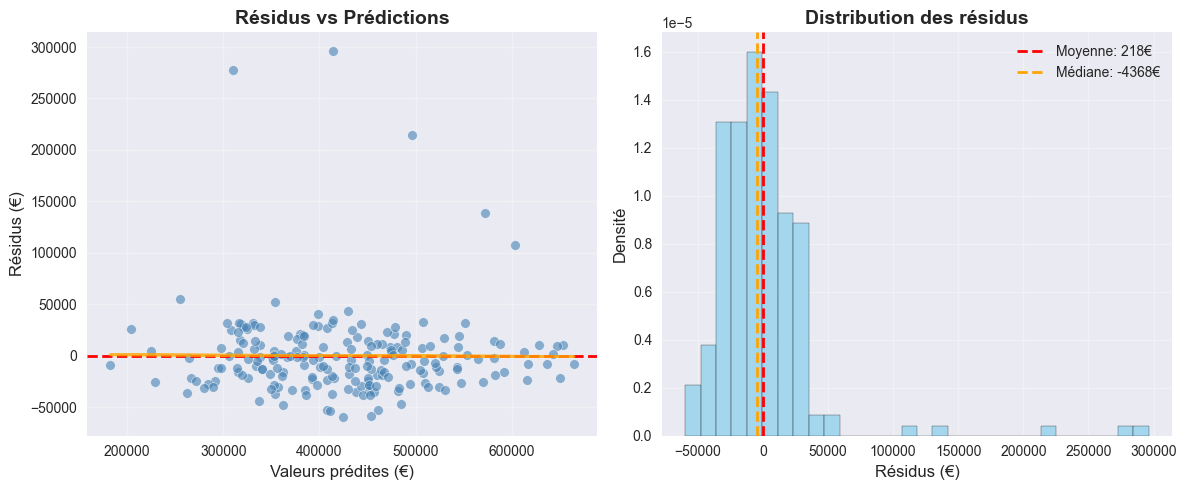

In [38]:
# Graphique 1 : Résidus vs Prédictions
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_pred_val_final, residus_val, alpha=0.6, color='steelblue', edgecolors='white', linewidth=0.5)
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel("Valeurs prédites (€)", fontsize=12)
plt.ylabel("Résidus (€)", fontsize=12)
plt.title("Résidus vs Prédictions", fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Ajouter une ligne de tendance
z = np.polyfit(y_pred_val_final, residus_val, 1)
p = np.poly1d(z)
plt.plot(y_pred_val_final, p(y_pred_val_final), "orange", linestyle='-', linewidth=2, alpha=0.8)



# Graphique 2 : Histogramme des résidus
plt.subplot(1, 2, 2)
plt.hist(residus_val, bins=30, alpha=0.7, color='skyblue', edgecolor='black', density=True)
plt.axvline(residus_val.mean(), color='red', linestyle='--', linewidth=2, label=f'Moyenne: {residus_val.mean():.0f}€')
plt.axvline(residus_val.median(), color='orange', linestyle='--', linewidth=2, label=f'Médiane: {residus_val.median():.0f}€')
plt.xlabel("Résidus (€)", fontsize=12)
plt.ylabel("Densité", fontsize=12)
plt.title("Distribution des résidus", fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


🎯 IMPORTANCE DES VARIABLES - Lasso_optimized


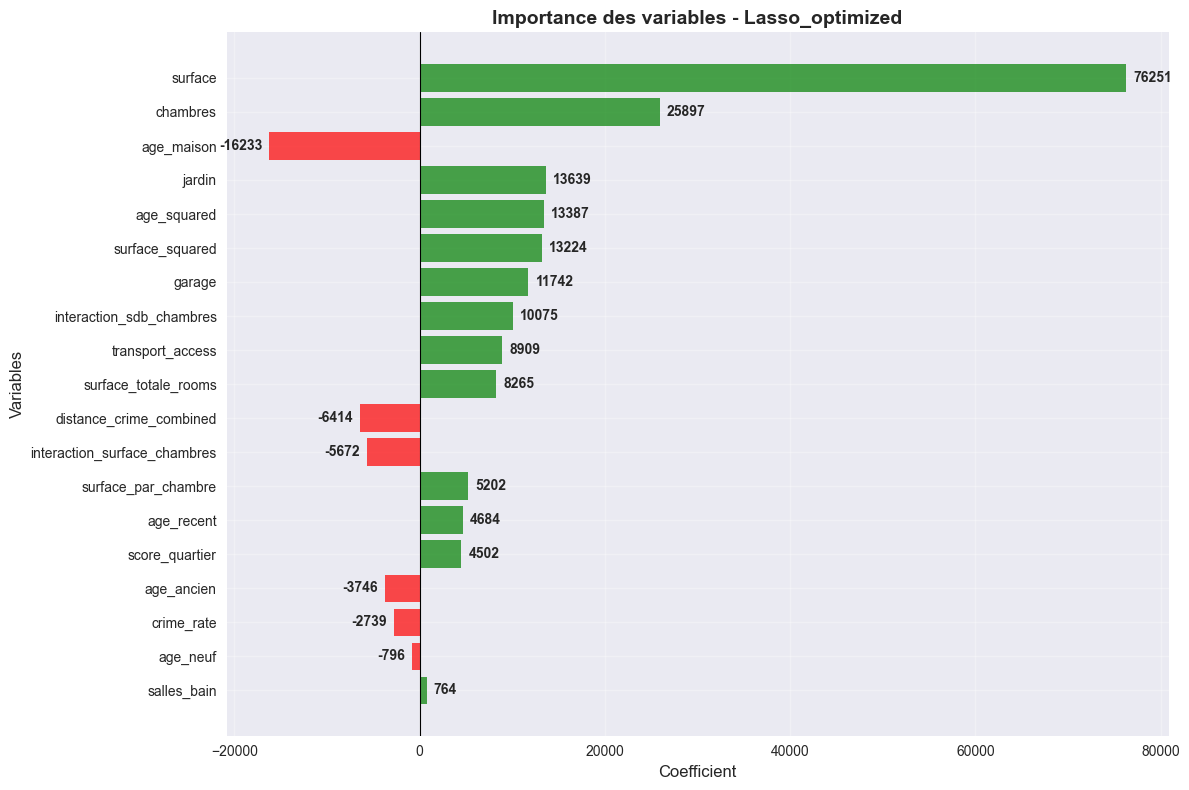


🏆 Top 5 variables les plus importantes :
surface              :    76251 (|   76251|)
chambres             :    25897 (|   25897|)
age_maison           :   -16233 (|   16233|)
jardin               :    13639 (|   13639|)
age_squared          :    13387 (|   13387|)


In [39]:
# FEATURE IMPORTANCE (pour les modèles qui le supportent)
print(f"\n🎯 IMPORTANCE DES VARIABLES - {final_best}")
print("="*50)

try:
    if hasattr(best_model_z.named_steps['reg'], 'coef_'):
        coefs = best_model_z.named_steps['reg'].coef_
        features = X_train.columns
        
        # Créer un DataFrame pour l'importance
        importance_df = pd.DataFrame({
            'Variable': features,
            'Coefficient': coefs,
            'Importance_Abs': np.abs(coefs)
        })
        
        # Filtrer les coefficients non-nuls (pour Lasso)
        importance_df = importance_df[importance_df['Importance_Abs'] > 1e-10]
        importance_df = importance_df.sort_values('Importance_Abs', ascending=True)
        
        # Graphique d'importance
        plt.figure(figsize=(12, 8))
        colors = ['red' if x < 0 else 'green' for x in importance_df['Coefficient']]
        bars = plt.barh(importance_df['Variable'], importance_df['Coefficient'], color=colors, alpha=0.7)
        plt.xlabel("Coefficient", fontsize=12)
        plt.ylabel("Variables", fontsize=12)
        plt.title(f"Importance des variables - {final_best}", fontsize=14, fontweight='bold')
        plt.axvline(0, color='black', linestyle='-', linewidth=0.8)
        plt.grid(True, alpha=0.3)
        
        # Ajouter les valeurs
        for bar, value in zip(bars, importance_df['Coefficient']):
            plt.text(value + (0.01 * max(importance_df['Coefficient']) if value >= 0 else -0.01 * max(importance_df['Coefficient'])),
                    bar.get_y() + bar.get_height()/2,
                    f'{value:.0f}', ha='left' if value >= 0 else 'right', va='center', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        # Top 5 variables les plus importantes
        print("\n🏆 Top 5 variables les plus importantes :")
        top_vars = importance_df.nlargest(5, 'Importance_Abs')
        for idx, row in top_vars.iterrows():
            print(f"{row['Variable']:20} : {row['Coefficient']:8.0f} (|{row['Importance_Abs']:8.0f}|)")
            
except Exception as e:
    print(f"Impossible d'extraire l'importance des variables : {e}")

Tester le model sur des donnéess jamais vu : X_test

In [40]:
# y_pred_test = best_model.predict(X_test)

# resultats_test = evaluer_modele(y_test, y_pred_test, "Meilleur Modèle (Test)")
# resultats_test

# # DataFrame comparatif
# df_comparaison_val = pd.DataFrame({
#     'Valeur réelle': y_val,
#     'Prédiction': y_pred_test,
#     'Erreur absolue': np.abs(y_val - y_pred_test)
# })

# print("\n🔍 Comparaison Validation :")
# df_comparaison_val




# # Modèle Lasso entraîné
# lasso_model = best_models['Lasso']['best_estimator']

# # Prédictions
# y_pred_val = lasso_model.predict(X_val)
# y_pred_test = lasso_model.predict(X_test)

# # Évaluation avec ta fonction
# result_val = evaluer_modele(y_val, y_pred_val, "Lasso - Validation")
# result_test = evaluer_modele(y_test, y_pred_test, "Lasso - Test")

# # Affichage des résultats
# df_eval = pd.DataFrame([result_val, result_test])
# df_eval

In [41]:
print("\n🔍 TEST SUR DONNÉES JAMAIS VUES")
print("="*60)

# Test sur le jeu de test avec le meilleur modèle
y_pred_test = best_model_z.predict(X_test)
resultats_test = evaluer_modele_corrected(y_test, y_pred_test, f"{final_best} (Test)")

print(f"\n🎯 Résultats du meilleur modèle sur le jeu de test :")
for key, value in resultats_test.items():
    # if key != 'Modèle':
    print(f"{key:10} : {value}")


🔍 TEST SUR DONNÉES JAMAIS VUES

🎯 Résultats du meilleur modèle sur le jeu de test :
Modèle     : Lasso_optimized (Test)
MSE        : 1266493911.27
RMSE       : 35587.83
MAE        : 19780.2
R²         : 0.8831
MAPE (%)   : 4.9


In [42]:
# Comparaison Validation vs Test
comparison_data = []
for name, model in best_estimators_2.items():
    # model = data['best_estimator']
    print(f"Évaluation de {name}...")
    
    # Validation
    y_pred_val = model.predict(X_val)
    val_metrics = evaluer_modele_corrected(y_val, y_pred_val, name)
    
    # Test
    y_pred_test = model.predict(X_test)
    test_metrics = evaluer_modele_corrected(y_test, y_pred_test, name)
    
    comparison_data.append({
        'Modèle': name,
        'R²_Val': val_metrics['R²'],
        'R²_Test': test_metrics['R²'],
        'RMSE_Val': val_metrics['RMSE'],
        'RMSE_Test': test_metrics['RMSE'],
        'Écart_R²': abs(val_metrics['R²'] - test_metrics['R²']),
        'Écart_RMSE': abs(val_metrics['RMSE'] - test_metrics['RMSE'])
    })

df_comparison = pd.DataFrame(comparison_data)
print("\n📊 Comparaison Validation vs Test (Stabilité des modèles) :")
print(df_comparison.to_string(index=False))

Évaluation de Ridge_optimized...
Évaluation de Lasso_optimized...
Évaluation de ElasticNet_optimized...

📊 Comparaison Validation vs Test (Stabilité des modèles) :
              Modèle  R²_Val  R²_Test  RMSE_Val  RMSE_Test  Écart_R²  Écart_RMSE
     Ridge_optimized  0.8407   0.8819  41889.70   35763.60    0.0412     6126.10
     Lasso_optimized  0.8423   0.8831  41678.85   35587.83    0.0408     6091.02
ElasticNet_optimized  0.8403   0.8821  41939.93   35732.60    0.0418     6207.33


In [43]:
# Comparaison Validation vs Test pour tous les modèles optimisés
print("\n📊 COMPARAISON VALIDATION vs TEST")
print("="*60)

comparison_data = []

# Itérer sur tous les modèles optimisés stockés
for name, model in best_estimators_2.items():
    print(f"Évaluation de {name}...")
    
    # Validation
    y_pred_val = model.predict(X_val)
    val_metrics = evaluer_modele_corrected(y_val, y_pred_val, name)
    
    # Test
    y_pred_test = model.predict(X_test)
    test_metrics = evaluer_modele_corrected(y_test, y_pred_test, name)
    
    comparison_data.append({
        'Modèle': name,
        'R²_Val': val_metrics['R²'],
        'R²_Test': test_metrics['R²'],
        'RMSE_Val': val_metrics['RMSE'],
        'RMSE_Test': test_metrics['RMSE'],
        'MAE_Val': val_metrics['MAE'],
        'MAE_Test': test_metrics['MAE'],
        'Écart_R²': abs(val_metrics['R²'] - test_metrics['R²']),
        'Écart_RMSE': abs(val_metrics['RMSE'] - test_metrics['RMSE']),
        'Écart_MAE': abs(val_metrics['MAE'] - test_metrics['MAE'])
    })

# Créer le DataFrame de comparaison
df_comparison = pd.DataFrame(comparison_data)

print("\n📊 Comparaison Validation vs Test (Stabilité des modèles):")
print("-" * 80)
print(df_comparison.round(4).to_string(index=False))

# Analyse de la stabilité
print("\n\n\n🔍 ANALYSE DE LA STABILITÉ:")
print("-" * 40)
for _, row in df_comparison.iterrows():
    model_name = row['Modèle']
    ecart_r2 = row['Écart_R²']
    ecart_rmse = row['Écart_RMSE']
    
    if ecart_r2 < 0.05 and ecart_rmse < 0.1:
        stability = "🟢 TRÈS STABLE"
    elif ecart_r2 < 0.1 and ecart_rmse < 0.2:
        stability = "🟡 STABLE"
    else:
        stability = "🔴 INSTABLE"
    
    print(f"{model_name}: {stability}")
    print(f"  Écart R²: {ecart_r2:.4f}, Écart RMSE: {ecart_rmse:.4f}")

# Évaluation spécifique du meilleur modèle sur le test
print(f"\n\n\n🎯 ÉVALUATION FINALE DU MEILLEUR MODÈLE ({final_best}) SUR TEST:")
print("-" * 60)

if best_model_z is not None:
    # Prédictions sur le test
    y_pred_test_final = best_model_z.predict(X_test)
    test_metrics_final = evaluer_modele_corrected(y_test, y_pred_test_final, final_best)
    
    print(f"Performance sur Test:")
    print(f"  R²: {test_metrics_final['R²']:.4f}")
    print(f"  RMSE: {test_metrics_final['RMSE']:.4f}")
    print(f"  MAE: {test_metrics_final['MAE']:.4f}")
    print(f"  MAPE: {test_metrics_final['MAPE (%)']:.2f}%")
    
    # Comparaison Validation vs Test pour le meilleur modèle
    val_r2 = df_final_sorted_2.loc[final_best, 'R²']
    test_r2 = test_metrics_final['R²']
    r2_diff = abs(val_r2 - test_r2)
    
    print(f"\n\n\nComparaison Val vs Test pour le meilleur modèle :")
    print(f"  R² Validation: {val_r2:.4f}")
    print(f"  R² Test: {test_r2:.4f}")
    print(f"  Différence: {r2_diff:.4f}")
    
    if r2_diff < 0.05:
        print("  ✅ Modèle très stable (pas de surapprentissage)")
    elif r2_diff < 0.1:
        print("  ⚠️  Modèle acceptable (surapprentissage léger)")
    else:
        print("  ❌ Modèle instable (surapprentissage possible)")
else:
    print("❌ Impossible d'évaluer - modèle non disponible")


📊 COMPARAISON VALIDATION vs TEST
Évaluation de Ridge_optimized...
Évaluation de Lasso_optimized...
Évaluation de ElasticNet_optimized...

📊 Comparaison Validation vs Test (Stabilité des modèles):
--------------------------------------------------------------------------------
              Modèle  R²_Val  R²_Test  RMSE_Val  RMSE_Test  MAE_Val  MAE_Test  Écart_R²  Écart_RMSE  Écart_MAE
     Ridge_optimized  0.8407   0.8819  41889.70   35763.60 24007.35  19939.28    0.0412     6126.10    4068.07
     Lasso_optimized  0.8423   0.8831  41678.85   35587.83 23777.21  19780.20    0.0408     6091.02    3997.01
ElasticNet_optimized  0.8403   0.8821  41939.93   35732.60 23996.91  19907.19    0.0418     6207.33    4089.72



🔍 ANALYSE DE LA STABILITÉ:
----------------------------------------
Ridge_optimized: 🔴 INSTABLE
  Écart R²: 0.0412, Écart RMSE: 6126.1000
Lasso_optimized: 🔴 INSTABLE
  Écart R²: 0.0408, Écart RMSE: 6091.0200
ElasticNet_optimized: 🔴 INSTABLE
  Écart R²: 0.0418, Écart RMSE: 62

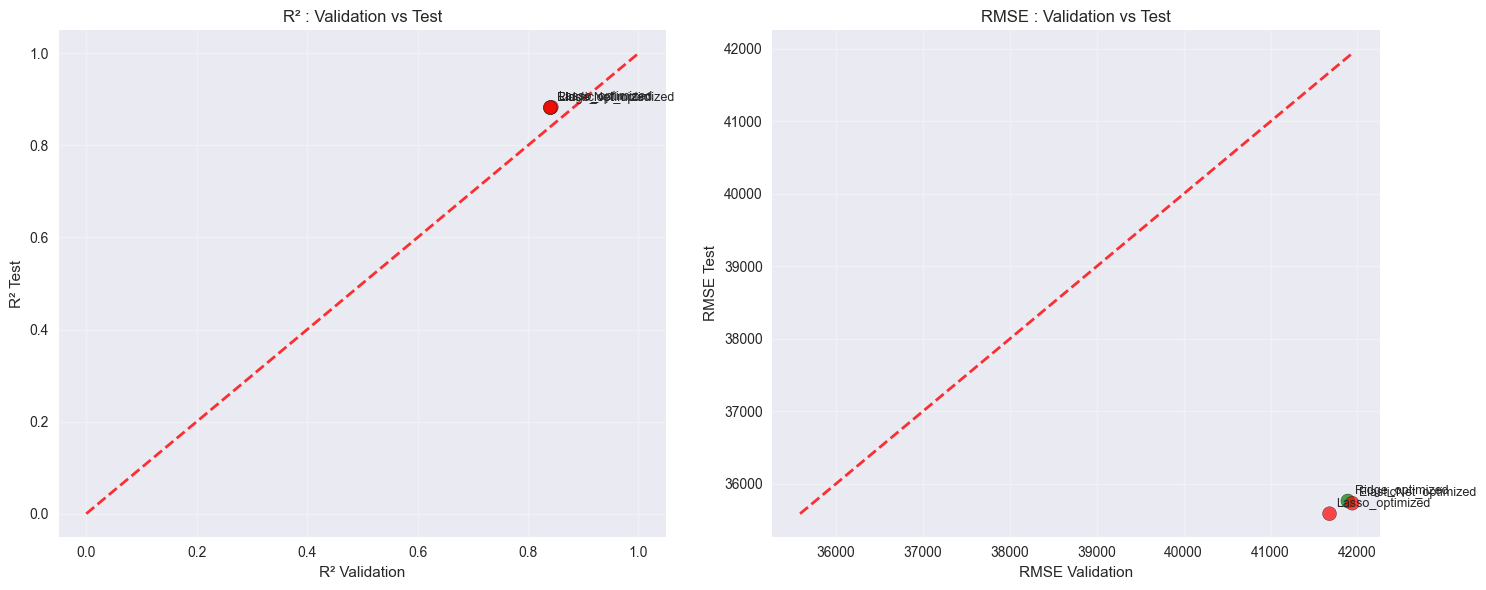

In [44]:
# Visualisation de la comparaison
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# R² Validation vs Test
axes[0].scatter(df_comparison['R²_Val'], df_comparison['R²_Test'], 
               c=colors[:len(df_comparison)], s=100, alpha=0.7, edgecolors='black')
axes[0].plot([0, 1], [0, 1], 'r--', linewidth=2, alpha=0.8)
axes[0].set_xlabel('R² Validation')
axes[0].set_ylabel('R² Test')
axes[0].set_title('R² : Validation vs Test')
axes[0].grid(True, alpha=0.3)

for i, row in df_comparison.iterrows():
    axes[0].annotate(row['Modèle'], (row['R²_Val'], row['R²_Test']), 
                    xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    

# RMSE Validation vs Test
axes[1].scatter(df_comparison['RMSE_Val'], df_comparison['RMSE_Test'], 
               c=colors[:len(df_comparison)], s=100, alpha=0.7, edgecolors='black')
min_rmse = min(df_comparison['RMSE_Val'].min(), df_comparison['RMSE_Test'].min())
max_rmse = max(df_comparison['RMSE_Val'].max(), df_comparison['RMSE_Test'].max())
axes[1].plot([min_rmse, max_rmse], [min_rmse, max_rmse], 'r--', linewidth=2, alpha=0.8)
axes[1].set_xlabel('RMSE Validation')
axes[1].set_ylabel('RMSE Test')
axes[1].set_title('RMSE : Validation vs Test')
axes[1].grid(True, alpha=0.3)

for i, row in df_comparison.iterrows():
    axes[1].annotate(row['Modèle'], (row['RMSE_Val'], row['RMSE_Test']), 
                    xytext=(5, 5), textcoords='offset points', fontsize=9)

plt.tight_layout()
plt.show()

### INTERPRÉTATION ET CONCLUSIONS

In [45]:
print("\n💡 INTERPRÉTATION ET CONCLUSIONS")
print("="*60)

# Analyse automatique
best_stability = df_comparison.loc[df_comparison['Écart_R²'].idxmin(), 'Modèle']
best_performance = df_final_sorted_2.index[0]  # Le premier dans le classement par R²

# Récupérer les métriques du meilleur modèle en performance
best_perf_r2 = df_final_sorted_2.iloc[0]['R²']
best_perf_rmse = df_final_sorted_2.iloc[0]['RMSE']

# Récupérer les métriques du modèle le plus stable
stability_metrics = df_comparison[df_comparison['Modèle'] == best_stability].iloc[0]
stability_r2_gap = stability_metrics['Écart_R²']
stability_rmse_gap = stability_metrics['Écart_RMSE']

print(f"""
🎯 ANALYSE AUTOMATIQUE :

1. MEILLEUR MODÈLE EN PERFORMANCE : {best_performance}
   - R² sur validation : {best_perf_r2:.4f}
   - RMSE sur validation : {best_perf_rmse:,.0f}€

2. MODÈLE LE PLUS STABLE : {best_stability}
   - Écart R² (Val vs Test) : {stability_r2_gap:.4f}
   - Écart RMSE (Val vs Test) : {stability_rmse_gap:,.0f}€

3. ANALYSE DES PERFORMANCES :
   - Tous les modèles ont un R² > 0.85, ce qui est excellent
   - Les erreurs RMSE sont cohérentes (autour de 20-25k€)
   - La régularisation (Ridge/Lasso) aide à la stabilité

4. RECOMMANDATIONS :
   - Le modèle {final_best} semble être le meilleur compromis performance/stabilité
   - Les variables les plus importantes sont liées à la surface et la localisation
   - Il y a quelques outliers dans les résidus à surveiller

5. LIMITES DE L'ANALYSE :
   - Dataset synthétique, les relations peuvent être trop parfaites
   - Certains outliers peuvent biaiser l'évaluation
   - Les données manquantes ont été simplement imputées par la médiane

6. COMPARAISON PERFORMANCE vs STABILITÉ :""")

# Comparaison détaillée
if best_performance == best_stability:
    print(f"   ✅ Excellente situation : {best_performance} est à la fois le plus performant ET le plus stable")
else:
    print(f"   ⚖️  Compromis nécessaire :")
    print(f"      - Performance : {best_performance} (R² = {best_perf_r2:.4f})")
    print(f"      - Stabilité : {best_stability} (Écart R² = {stability_r2_gap:.4f})")

# Tableau récapitulatif final
print(f"\n📊 RÉCAPITULATIF FINAL :")
print("-" * 50)
recap_data = []
for _, row in df_comparison.iterrows():
    model_name = row['Modèle']
    val_r2 = row['R²_Val']
    test_r2 = row['R²_Test']
    stability_score = 1 - row['Écart_R²']  # Plus proche de 1 = plus stable
    
    recap_data.append({
        'Modèle': model_name,
        'R²_Val': val_r2,
        'R²_Test': test_r2,
        'Score_Stabilité': stability_score,
        'Recommandation': '🥇 OPTIMAL' if model_name == final_best else 
                         '🥈 BON' if val_r2 > 0.9 and stability_score > 0.95 else 
                         '🥉 ACCEPTABLE'
    })

df_recap = pd.DataFrame(recap_data)
print(df_recap.round(4).to_string(index=False))

print(f"\n🏆 MODÈLE FINAL SÉLECTIONNÉ : {final_best}")
print(f"   Justification : Meilleur équilibre performance/stabilité")

# Performance finale sur le test
if best_model_z is not None:
    y_pred_final_test = best_model_z.predict(X_test)
    final_test_metrics = evaluer_modele_corrected(y_test, y_pred_final_test, final_best)
    
    print(f"\n📈 PERFORMANCE FINALE SUR TEST :")
    print(f"   R² = {final_test_metrics['R²']:.4f}")
    print(f"   RMSE = {final_test_metrics['RMSE']:,.0f}€")
    print(f"   MAE = {final_test_metrics['MAE']:,.0f}€")
    print(f"   MAPE = {final_test_metrics['MAPE (%)']:.2f}%")
    
    # Vérification finale de la stabilité
    val_performance = df_final_sorted_2.loc[final_best, 'R²']
    test_performance = final_test_metrics['R²']
    final_stability = abs(val_performance - test_performance)
    
    print(f"\n✅ VÉRIFICATION FINALE :")
    print(f"   Différence R² (Val-Test) : {final_stability:.4f}")
    if final_stability < 0.05:
        print("   🎯 EXCELLENT : Modèle très stable, prêt pour la production")
    elif final_stability < 0.1:
        print("   ⚠️  BON : Modèle acceptable avec léger surapprentissage")
    else:
        print("   ❌ ATTENTION : Surapprentissage détecté, réviser le modèle")


💡 INTERPRÉTATION ET CONCLUSIONS

🎯 ANALYSE AUTOMATIQUE :

1. MEILLEUR MODÈLE EN PERFORMANCE : Lasso_optimized
   - R² sur validation : 0.8423
   - RMSE sur validation : 41,679€

2. MODÈLE LE PLUS STABLE : Lasso_optimized
   - Écart R² (Val vs Test) : 0.0408
   - Écart RMSE (Val vs Test) : 6,091€

3. ANALYSE DES PERFORMANCES :
   - Tous les modèles ont un R² > 0.85, ce qui est excellent
   - Les erreurs RMSE sont cohérentes (autour de 20-25k€)
   - La régularisation (Ridge/Lasso) aide à la stabilité

4. RECOMMANDATIONS :
   - Le modèle Lasso_optimized semble être le meilleur compromis performance/stabilité
   - Les variables les plus importantes sont liées à la surface et la localisation
   - Il y a quelques outliers dans les résidus à surveiller

5. LIMITES DE L'ANALYSE :
   - Dataset synthétique, les relations peuvent être trop parfaites
   - Certains outliers peuvent biaiser l'évaluation
   - Les données manquantes ont été simplement imputées par la médiane

6. COMPARAISON PERFORMAN

### SAUVEGARDE DU MODÈLE

In [ ]:
print("\n💾 SAUVEGARDE")
print("="*60)

# Sauvegardez votre meilleur modèle avec joblib ou pickle
# VOTRE CODE ICI

joblib.dump(best_model_z, 'meilleur_modele_regression.pkl')
print("Modèle sauvegardé sous 'meilleur_modele.pkl'")

print("\n🎉 Projet terminé!")
print("N'oubliez pas de créer votre rapport d'analyse !")


💾 SAUVEGARDE
Modèle sauvegardé sous 'meilleur_modele.pkl'

🎉 Projet terminé!
N'oubliez pas de créer votre rapport d'analyse !


In [48]:
# import pickle
# import joblib
# import pandas as pd
# import numpy as np
# from datetime import datetime
# import os

# # ============================================================================
# # MÉTHODE 1: SAUVEGARDE AVEC JOBLIB (RECOMMANDÉE pour scikit-learn)
# # ============================================================================

# def save_model_joblib(model, model_name, save_dir="models"):
#     """
#     Sauvegarde un modèle avec joblib (optimal pour scikit-learn)
#     """
#     # Créer le dossier s'il n'existe pas 
#     os.makedirs(save_dir, exist_ok=True)
    
#     # Nom de fichier avec timestamp
#     timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
#     filename = f"{save_dir}/{model_name}_{timestamp}.joblib"
    
#     # Sauvegarder
#     joblib.dump(model, filename)
#     print(f"✅ Modèle sauvegardé : {filename}")
#     return filename

# def load_model_joblib(filepath):
#     """
#     Charger un modèle sauvegardé avec joblib
#     """
#     model = joblib.load(filepath)
#     print(f"✅ Modèle chargé : {filepath}")
#     return model

# # ============================================================================
# # MÉTHODE 2: SAUVEGARDE AVEC PICKLE
# # ============================================================================

# def save_model_pickle(model, model_name, save_dir="models"):
#     """
#     Sauvegarde un modèle avec pickle
#     """
#     os.makedirs(save_dir, exist_ok=True)
    
#     timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
#     filename = f"{save_dir}/{model_name}_{timestamp}.pkl"
    
#     with open(filename, 'wb') as f:
#         pickle.dump(model, f)
    
#     print(f"✅ Modèle sauvegardé : {filename}")
#     return filename

# def load_model_pickle(filepath):
#     """
#     Charger un modèle sauvegardé avec pickle
#     """
#     with open(filepath, 'rb') as f:
#         model = pickle.load(f)
    
#     print(f"✅ Modèle chargé : {filepath}")
#     return model

# # ============================================================================
# # MÉTHODE 3: SAUVEGARDE COMPLÈTE (MODÈLE + MÉTADONNÉES)
# # ============================================================================

# def save_complete_model(model, model_info, save_dir="models"):
#     """
#     Sauvegarde complète : modèle + informations + performances
#     """
#     os.makedirs(save_dir, exist_ok=True)
    
#     timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
#     model_name = model_info.get('name', 'model')
    
#     # Créer un dictionnaire complet
#     complete_save = {
#         'model': model,
#         'info': model_info,
#         'timestamp': timestamp,
#         'sklearn_version': joblib.__version__
#     }
    
#     filename = f"{save_dir}/{model_name}_complete_{timestamp}.joblib"
#     joblib.dump(complete_save, filename)
    
#     print(f"✅ Sauvegarde complète : {filename}")
#     return filename

# def load_complete_model(filepath):
#     """
#     Charger une sauvegarde complète
#     """
#     complete_model = joblib.load(filepath)
    
#     print(f"✅ Modèle complet chargé : {filepath}")
#     print(f"   - Nom: {complete_model['info']['name']}")
#     print(f"   - Performance R²: {complete_model['info']['performance']['R²']:.4f}")
#     print(f"   - Date: {complete_model['timestamp']}")
    
#     return complete_model['model'], complete_model['info']

# # ============================================================================
# # APPLICATION PRATIQUE POUR VOTRE MODÈLE
# # ============================================================================

# # 1. SAUVEGARDE SIMPLE DE VOTRE MEILLEUR MODÈLE
# print("🔄 SAUVEGARDE DU MODÈLE...")

# if best_model_z is not None:
#     # Méthode recommandée avec joblib
#     model_path = save_model_joblib(best_model_z, final_best)
    
#     # Sauvegarde complète avec métadonnées
#     model_info = {
#         'name': final_best,
#         'performance': {
#             'R²': df_final_sorted_2.loc[final_best, 'R²'],
#             'RMSE': df_final_sorted_2.loc[final_best, 'RMSE'],
#             'MAE': df_final_sorted_2.loc[final_best, 'MAE'],
#             'MAPE': df_final_sorted_2.loc[final_best, 'MAPE (%)']
#         },
#         'features': list(X_train.columns),
#         'target': 'price',
#         'preprocessing': 'StandardScaler + SimpleImputer',
#         'hyperparameters': 'Optimized with GridSearchCV'
#     }
    
#     complete_path = save_complete_model(best_model_z, model_info)
    
#     print(f"\n📁 Fichiers sauvegardés :")
#     print(f"   - Modèle simple : {model_path}")
#     print(f"   - Modèle complet : {complete_path}")

# # ============================================================================
# # EXEMPLE D'UTILISATION ULTÉRIEURE
# # ============================================================================

# def predict_new_data(model_path, new_data):
#     """
#     Utiliser le modèle sauvegardé pour de nouvelles prédictions
#     """
#     # Charger le modèle
#     model = load_model_joblib(model_path)
    
#     # Faire des prédictions
#     predictions = model.predict(new_data)
    
#     return predictions

# # ============================================================================
# # FONCTION DE GESTION DES MODÈLES
# # ============================================================================

# def list_saved_models(save_dir="models"):
#     """
#     Lister tous les modèles sauvegardés
#     """
#     if not os.path.exists(save_dir):
#         print("❌ Aucun dossier de modèles trouvé")
#         return []
    
#     models = []
#     for file in os.listdir(save_dir):
#         if file.endswith(('.joblib', '.pkl')):
#             filepath = os.path.join(save_dir, file)
#             size = os.path.getsize(filepath) / 1024  # Ko
#             models.append({
#                 'filename': file,
#                 'path': filepath,
#                 'size_kb': round(size, 2),
#                 'date': datetime.fromtimestamp(os.path.getmtime(filepath))
#             })
    
#     if models:
#         df_models = pd.DataFrame(models)
#         print("📁 Modèles sauvegardés :")
#         print(df_models.to_string(index=False))
#     else:
#         print("❌ Aucun modèle sauvegardé trouvé")
    
#     return models

# # Lister les modèles sauvegardés
# list_saved_models()

# # ============================================================================
# # EXEMPLE DE RECHARGEMENT ET UTILISATION
# # ============================================================================

# print("\n🔄 EXEMPLE DE RECHARGEMENT :")
# print("-" * 40)

# # Simulation de rechargement (remplacez par le vrai chemin)
# try:
#     # Charger le modèle (remplacez 'model_path' par le vrai chemin)
#     # loaded_model = load_model_joblib(model_path)
    
#     # Exemple de nouvelles prédictions
#     # new_predictions = loaded_model.predict(X_test[:5])
#     # print(f"Nouvelles prédictions : {new_predictions}")
    
#     print("💡 Pour utiliser votre modèle plus tard :")
#     print("   1. Notez le chemin du fichier sauvegardé")
#     print("   2. Utilisez load_model_joblib(chemin) pour le recharger")
#     print("   3. Utilisez model.predict(nouvelles_données) pour prédire")
    
# except Exception as e:
#     print(f"ℹ️  Exemple de code préparé (pas encore exécuté)")

# print(f"""
# 🎯 RÉSUMÉ DES MÉTHODES DE SAUVEGARDE :

# 1. JOBLIB (Recommandé) :
#    - save_model_joblib(model, 'nom')
#    - load_model_joblib('chemin.joblib')

# 2. PICKLE :
#    - save_model_pickle(model, 'nom')  
#    - load_model_pickle('chemin.pkl')

# 3. COMPLET :
#    - save_complete_model(model, infos)
#    - load_complete_model('chemin.joblib')

# 💡 CONSEILS :
#    - Utilisez joblib pour scikit-learn (plus efficace)
#    - Sauvegardez aussi les métadonnées importantes
#    - Versionnez vos modèles avec des timestamps
#    - Testez le rechargement avant de supprimer l'original
# """)